## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


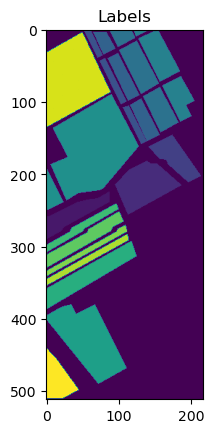

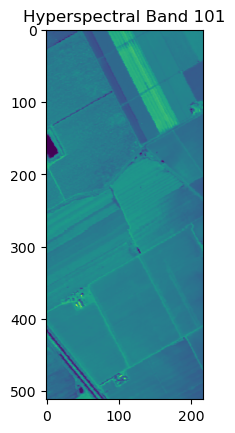

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices for clas


 -- Test set created with: 
	53969 samples
	shape (53969, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(80, 5, 5, 204)
(80, 5, 5, 204)
(53969, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1576, PSNR: 7.2061


	 Training Batch [200/677], Loss: 0.0851, PSNR: 9.7769


	 Training Batch [400/677], Loss: 0.0457, PSNR: 12.5306


	 Training Batch [600/677], Loss: 0.0255, PSNR: 14.9900


Epoch [1/50] Training Loss: 0.0667, PSNR: 11.6292
	[Val]   Batch [1/170] Loss: 0.0213, PSNR: 15.8021
	[Val]   Batch [10/170] Loss: 0.0209, PSNR: 15.9743
	[Val]   Batch [20/170] Loss: 0.0210, PSNR: 15.8745
	[Val]   Batch [30/170] Loss: 0.0218, PSNR: 15.6657
	[Val]   Batch [40/170] Loss: 0.0219, PSNR: 15.7390


	[Val]   Batch [50/170] Loss: 0.0207, PSNR: 15.9537
	[Val]   Batch [60/170] Loss: 0.0217, PSNR: 15.8256
	[Val]   Batch [70/170] Loss: 0.0212, PSNR: 15.9055
	[Val]   Batch [80/170] Loss: 0.0216, PSNR: 15.7249
	[Val]   Batch [90/170] Loss: 0.0209, PSNR: 15.9632


	[Val]   Batch [100/170] Loss: 0.0210, PSNR: 15.8815
	[Val]   Batch [110/170] Loss: 0.0210, PSNR: 15.8727
	[Val]   Batch [120/170] Loss: 0.0198, PSNR: 14.1902
	[Val]   Batch [130/170] Loss: 0.0209, PSNR: 15.9648
	[Val]   Batch [140/170] Loss: 0.0205, PSNR: 16.0313


	[Val]   Batch [150/170] Loss: 0.0219, PSNR: 15.7684
	[Val]   Batch [160/170] Loss: 0.0216, PSNR: 15.8076
	[Val]   Batch [170/170] Loss: 0.0224, PSNR: 15.0983
Epoch [1/50] Validation Loss: 0.0213, PSNR: 15.7938

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0202, PSNR: 16.0225


	 Training Batch [200/677], Loss: 0.0145, PSNR: 17.5611


	 Training Batch [400/677], Loss: 0.0105, PSNR: 18.4293


	 Training Batch [600/677], Loss: 0.0088, PSNR: 19.5814


Epoch [2/50] Training Loss: 0.0131, PSNR: 18.0639
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6428
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9816
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8482
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4533
	[Val]   Batch [40/170] Loss: 0.0093, PSNR: 19.4459


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0179
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5871
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.6961
	[Val]   Batch [80/170] Loss: 0.0090, PSNR: 19.5438
	[Val]   Batch [90/170] Loss: 0.0086, PSNR: 19.8424


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7499
	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8157
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4803
	[Val]   Batch [130/170] Loss: 0.0086, PSNR: 19.8368
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1375


	[Val]   Batch [150/170] Loss: 0.0093, PSNR: 19.4762
	[Val]   Batch [160/170] Loss: 0.0090, PSNR: 19.5818
	[Val]   Batch [170/170] Loss: 0.0094, PSNR: 18.8862
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6848

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0081, PSNR: 19.9084


	 Training Batch [200/677], Loss: 0.0077, PSNR: 20.2094


	 Training Batch [400/677], Loss: 0.0065, PSNR: 20.9996


	 Training Batch [600/677], Loss: 0.0046, PSNR: 22.5957


Epoch [3/50] Training Loss: 0.0065, PSNR: 21.0039
	[Val]   Batch [1/170] Loss: 0.0047, PSNR: 22.3379
	[Val]   Batch [10/170] Loss: 0.0045, PSNR: 22.6239
	[Val]   Batch [20/170] Loss: 0.0046, PSNR: 22.5100
	[Val]   Batch [30/170] Loss: 0.0050, PSNR: 22.0855
	[Val]   Batch [40/170] Loss: 0.0050, PSNR: 22.1146
	[Val]   Batch [50/170] Loss: 0.0045, PSNR: 22.6149


	[Val]   Batch [60/170] Loss: 0.0049, PSNR: 22.2410
	[Val]   Batch [70/170] Loss: 0.0048, PSNR: 22.3897
	[Val]   Batch [80/170] Loss: 0.0048, PSNR: 22.2274
	[Val]   Batch [90/170] Loss: 0.0047, PSNR: 22.4791
	[Val]   Batch [100/170] Loss: 0.0047, PSNR: 22.3396


	[Val]   Batch [110/170] Loss: 0.0046, PSNR: 22.4542
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 21.0686
	[Val]   Batch [130/170] Loss: 0.0047, PSNR: 22.4398
	[Val]   Batch [140/170] Loss: 0.0043, PSNR: 22.8108
	[Val]   Batch [150/170] Loss: 0.0051, PSNR: 22.1356


	[Val]   Batch [160/170] Loss: 0.0049, PSNR: 22.2543
	[Val]   Batch [170/170] Loss: 0.0050, PSNR: 21.5933
Epoch [3/50] Validation Loss: 0.0047, PSNR: 22.3420

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0046, PSNR: 22.4016


	 Training Batch [200/677], Loss: 0.0042, PSNR: 22.9287


	 Training Batch [400/677], Loss: 0.0039, PSNR: 23.2530


	 Training Batch [600/677], Loss: 0.0031, PSNR: 24.1955


Epoch [4/50] Training Loss: 0.0037, PSNR: 23.4864
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.8326
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0759
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.9397
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4874
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.7071


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9456
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.7187
	[Val]   Batch [70/170] Loss: 0.0026, PSNR: 24.9516
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.7609


	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.9295
	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6739
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9666
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.2466
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7580


	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.2381
	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.6568
	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.7797
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.1113
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7920

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0027, PSNR: 24.7006


	 Training Batch [200/677], Loss: 0.0025, PSNR: 25.1611


	 Training Batch [400/677], Loss: 0.0023, PSNR: 25.5252


	 Training Batch [600/677], Loss: 0.0024, PSNR: 25.3715


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3175
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3280
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.5656
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.3677
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8844
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2738
	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.4007


	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1725
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.5041
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2396
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4450
	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0561


	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5363
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6450
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1214
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7451
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.0920


	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2707
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.4912
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2450

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0019, PSNR: 26.3144


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.7696


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.8512


	 Training Batch [600/677], Loss: 0.0018, PSNR: 26.3916


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5685
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6860
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.9338
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6861
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.1615
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6967


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6719
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4959
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9098
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6076
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7893


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3139
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9997
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.8612
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3790
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1074


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4168
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6296
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8932
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5788

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.5118


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.9236


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.6460


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.0416


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5543
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.7366
	[Val]   Batch [10/170] Loss: 0.0010, PSNR: 28.9763
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6949
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.1414
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.7836
	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.6524


	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.5122
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 29.0047
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6546
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.8612
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2928


	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.1265
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7994
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3658
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.1631
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.4097


	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6639
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9462
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.6007

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 28.0115


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.3946


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.8572


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.5583


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3448
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6684
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 29.9371
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.6407
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 29.0556
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.7565
	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.5136


	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.4486
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9735
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.6425
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.8203
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1985


	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.1475
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.6364
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.2754
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.1302
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3452


	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5969
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.9585
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.5345

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.7079


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.4960


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.7726


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.1796


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0764
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.4854
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.7536
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.4456
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.8676
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.5859


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2980
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.2508
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.7629
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.4782
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6588


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 30.0082
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 30.9724
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.4214
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0666
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.9729


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.1392
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.3712
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.7723
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.3368

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.3341


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.1084


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.7893


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.3590


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7160
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.3315
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.6155
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.2791
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.7275
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.4158
	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.0643


	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.1176
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.6106
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.3633
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.5717


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.9322
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.8860
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.2615
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.9896
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 31.8333


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 31.0185
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.2027
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.7443
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.1990

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.4445


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.1215


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4883


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.2821


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2875
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8540
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1315
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7465
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.3122
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9496


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5400
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6892
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.1104
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9141
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1698


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5588
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.3795
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8067
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.6114


	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3261
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.6079
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.7116
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3606
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7309

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.9353


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.6076


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1049


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5725


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.8196
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.7347
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.1212
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.6365
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.2606
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.8470
	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.3879


	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.6178
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.9392
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.9193
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.1052
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.4970


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3263
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.6135
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.5705
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.2489
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5727


	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.5545
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.5461
Epoch [12/50] Validation Loss: 0.0004, PSNR: 32.6597

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 30.6389


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5769


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.0452


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1507


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2840
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.1790
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.5471
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.0118
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.7459
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.3180


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.8312
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0868
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3495
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.3712
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6431


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0186
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.7582
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.1070
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.0816
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7154


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0543
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.9541
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.9390
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.0987

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.9015


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.7308


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1103


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1121


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6923
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.8544
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.2371
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.6803
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4501
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.9729


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4011
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8028
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0181
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.1141
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3806


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.7493
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4580
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7438
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.8243


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3880
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.7690
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6038
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.8564
Epoch [14/50] Validation Loss: 0.0003, PSNR: 33.7959

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.6853


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5124


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.6750


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3942


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0488
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2877
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.7196
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.0991
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.9280
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.4776


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8039
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.2973
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.4503
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.5907
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.8941


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.2549
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8867
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.1795
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.3406
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8376


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.2934
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.0055
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.4026
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.2514

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.5515


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9212


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1213


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1122


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3247
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.7762
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.1452
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.4743
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.4264
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.8675


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2274
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7952
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.8867
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 35.0852
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3807


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7434
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.3638
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.6170
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8407
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.2931


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.7767
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.4410
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.9860
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.7048

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1851


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.5281


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.2551


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2797


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5705
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9567
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.3138
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6032
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6234
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0407


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4278
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9809
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0320
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2498
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.6114


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9677
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5260
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.8618
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0614
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4663


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9421
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5955
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.1325
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8795
Early stopping triggered at epoch 17. No improvement for 3 epochs.


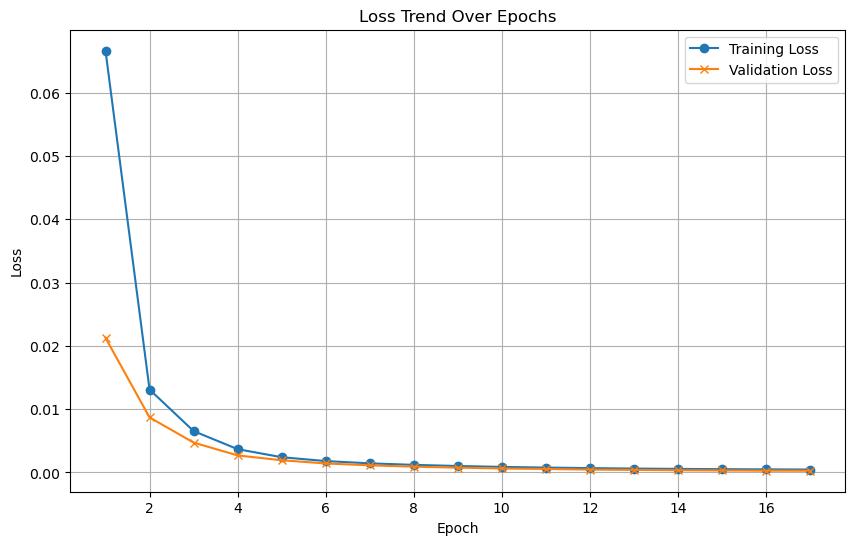

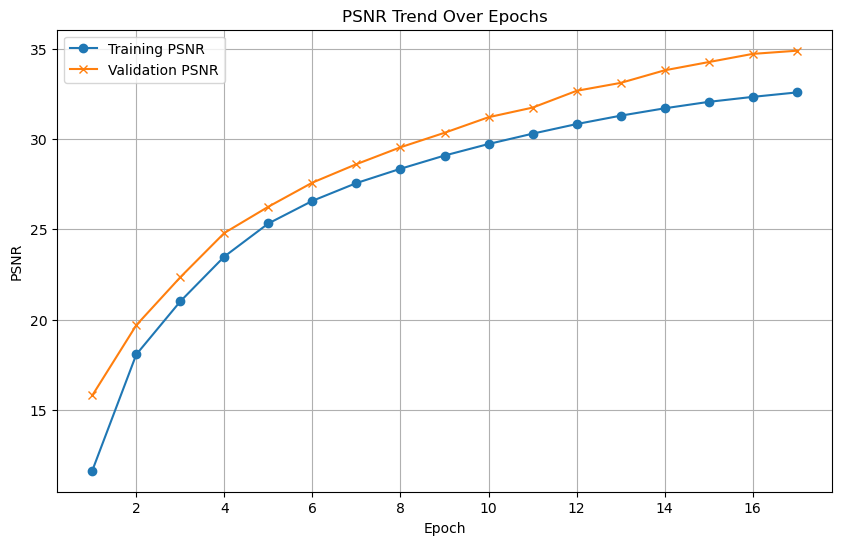

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7902
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7795. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7346
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss improved from 2.7795 to 2.7794. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6877
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss improved from 2.7794 to 2.7793. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6640
    Validation Batch [1/1], Loss: 2.7792
Validation Loss: 2.7792, Validation Accuracy: 6.25%
Validation loss improved from 2.7793 to 2.7792. Saving model...

LOG: Epoch [5/1000] - 

Epoch [21/1000] completed, Average Training Loss: 2.4529
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 6.25%
Validation loss improved from 2.7748 to 2.7742. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4636
    Validation Batch [1/1], Loss: 2.7736
Validation Loss: 2.7736, Validation Accuracy: 6.25%
Validation loss improved from 2.7742 to 2.7736. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4287
    Validation Batch [1/1], Loss: 2.7727
Validation Loss: 2.7727, Validation Accuracy: 6.25%
Validation loss improved from 2.7736 to 2.7727. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4294
    Validation Batch [1/1], Loss: 2.7718
Validation Loss: 2.7718, Validation Accuracy: 6.25%
Validation loss improved from 2.7727 to 2.7718. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/10

    Validation Batch [1/1], Loss: 2.5263
Validation Loss: 2.5263, Validation Accuracy: 27.50%
Validation loss improved from 2.5475 to 2.5263. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.1629
    Validation Batch [1/1], Loss: 2.5073
Validation Loss: 2.5073, Validation Accuracy: 30.00%
Validation loss improved from 2.5263 to 2.5073. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.1653
    Validation Batch [1/1], Loss: 2.4860
Validation Loss: 2.4860, Validation Accuracy: 30.00%
Validation loss improved from 2.5073 to 2.4860. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.1960
    Validation Batch [1/1], Loss: 2.4675
Validation Loss: 2.4675, Validation Accuracy: 30.00%
Validation loss improved from 2.4860 to 2.4675. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.1554
    Vali

Epoch [79/1000] completed, Average Training Loss: 1.9373
    Validation Batch [1/1], Loss: 2.0274
Validation Loss: 2.0274, Validation Accuracy: 62.50%
Validation loss improved from 2.0454 to 2.0274. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.8931
    Validation Batch [1/1], Loss: 2.0253
Validation Loss: 2.0253, Validation Accuracy: 65.00%
Validation loss improved from 2.0274 to 2.0253. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.8972
    Validation Batch [1/1], Loss: 2.0208
Validation Loss: 2.0208, Validation Accuracy: 63.75%
Validation loss improved from 2.0253 to 2.0208. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.8525
    Validation Batch [1/1], Loss: 2.0045
Validation Loss: 2.0045, Validation Accuracy: 65.00%
Validation loss improved from 2.0208 to 2.0045. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [8

Epoch [110/1000] completed, Average Training Loss: 1.6657
    Validation Batch [1/1], Loss: 1.7543
Validation Loss: 1.7543, Validation Accuracy: 77.50%
Validation loss improved from 1.7831 to 1.7543. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.6319
    Validation Batch [1/1], Loss: 1.7583
Validation Loss: 1.7583, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.6541
    Validation Batch [1/1], Loss: 1.7674
Validation Loss: 1.7674, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.6566
    Validation Batch [1/1], Loss: 1.7676
Validation Loss: 1.7676, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.5749
Validation Loss: 1.5749, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.4200
    Validation Batch [1/1], Loss: 1.5597
Validation Loss: 1.5597, Validation Accuracy: 78.75%
Validation loss improved from 1.5714 to 1.5597. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.3279
    Validation Batch [1/1], Loss: 1.5711
Validation Loss: 1.5711, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2988
    Validation Batch [1/1], Loss: 1.5696
Validation Loss: 1.5696, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.3254
    Validation Batch [1/1], Loss: 1.5327
Vali

Epoch [169/1000] completed, Average Training Loss: 1.1201
    Validation Batch [1/1], Loss: 1.3584
Validation Loss: 1.3584, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.0639
    Validation Batch [1/1], Loss: 1.3176
Validation Loss: 1.3176, Validation Accuracy: 80.00%
Validation loss improved from 1.3265 to 1.3176. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.1353
    Validation Batch [1/1], Loss: 1.3026
Validation Loss: 1.3026, Validation Accuracy: 82.50%
Validation loss improved from 1.3176 to 1.3026. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.0826
    Validation Batch [1/1], Loss: 1.3203
Validation Loss: 1.3203, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Av

    Validation Batch [1/1], Loss: 1.1272
Validation Loss: 1.1272, Validation Accuracy: 78.75%
Validation loss improved from 1.1336 to 1.1272. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.8761
    Validation Batch [1/1], Loss: 1.1118
Validation Loss: 1.1118, Validation Accuracy: 78.75%
Validation loss improved from 1.1272 to 1.1118. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.8910
    Validation Batch [1/1], Loss: 1.1008
Validation Loss: 1.1008, Validation Accuracy: 80.00%
Validation loss improved from 1.1118 to 1.1008. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.8606
    Validation Batch [1/1], Loss: 1.1152
Validation Loss: 1.1152, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.9546
    Validation 

    Validation Batch [1/1], Loss: 0.9539
Validation Loss: 0.9539, Validation Accuracy: 82.50%
Validation loss improved from 0.9554 to 0.9539. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7956
    Validation Batch [1/1], Loss: 0.9492
Validation Loss: 0.9492, Validation Accuracy: 82.50%
Validation loss improved from 0.9539 to 0.9492. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7328
    Validation Batch [1/1], Loss: 0.9528
Validation Loss: 0.9528, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.7127
    Validation Batch [1/1], Loss: 0.9618
Validation Loss: 0.9618, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7276
    Validation Batch [1/1], Lo

Epoch [258/1000] completed, Average Training Loss: 0.5578
    Validation Batch [1/1], Loss: 0.8325
Validation Loss: 0.8325, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5994
    Validation Batch [1/1], Loss: 0.8244
Validation Loss: 0.8244, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5610
    Validation Batch [1/1], Loss: 0.8158
Validation Loss: 0.8158, Validation Accuracy: 85.00%
Validation loss improved from 0.8240 to 0.8158. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5550
    Validation Batch [1/1], Loss: 0.8052
Validation Loss: 0.8052, Validation Accuracy: 82.50%
Validation loss improved from 0.8158 to 0.8052. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Av

Epoch [288/1000] completed, Average Training Loss: 0.4850
    Validation Batch [1/1], Loss: 0.7381
Validation Loss: 0.7381, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4502
    Validation Batch [1/1], Loss: 0.7422
Validation Loss: 0.7422, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4503
    Validation Batch [1/1], Loss: 0.7386
Validation Loss: 0.7386, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4263
    Validation Batch [1/1], Loss: 0.7401
Validation Loss: 0.7401, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4825
  

    Validation Batch [1/1], Loss: 0.6255
Validation Loss: 0.6255, Validation Accuracy: 87.50%
Validation loss improved from 0.6404 to 0.6255. Saving model...

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3400
    Validation Batch [1/1], Loss: 0.6353
Validation Loss: 0.6353, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.3505
    Validation Batch [1/1], Loss: 0.6361
Validation Loss: 0.6361, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3248
    Validation Batch [1/1], Loss: 0.6469
Validation Loss: 0.6469, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3408
    Validation Batch [1/1], Loss: 0.6383
Vali

Epoch [350/1000] completed, Average Training Loss: 0.3073
    Validation Batch [1/1], Loss: 0.6097
Validation Loss: 0.6097, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.2386
    Validation Batch [1/1], Loss: 0.6467
Validation Loss: 0.6467, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.2584
    Validation Batch [1/1], Loss: 0.6135
Validation Loss: 0.6135, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2827
    Validation Batch [1/1], Loss: 0.5819
Validation Loss: 0.5819, Validation Accuracy: 86.25%
Validation loss improved from 0.5842 to 0.5819. Saving model...

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training 

Epoch [380/1000] completed, Average Training Loss: 0.2227
    Validation Batch [1/1], Loss: 0.5177
Validation Loss: 0.5177, Validation Accuracy: 86.25%
Validation loss improved from 0.5207 to 0.5177. Saving model...

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2291
    Validation Batch [1/1], Loss: 0.5254
Validation Loss: 0.5254, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2268
    Validation Batch [1/1], Loss: 0.5380
Validation Loss: 0.5380, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2310
    Validation Batch [1/1], Loss: 0.5460
Validation Loss: 0.5460, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training 

Epoch [409/1000] completed, Average Training Loss: 0.1707
    Validation Batch [1/1], Loss: 0.5181
Validation Loss: 0.5181, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1795
    Validation Batch [1/1], Loss: 0.4894
Validation Loss: 0.4894, Validation Accuracy: 87.50%
Validation loss improved from 0.4899 to 0.4894. Saving model...

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.2182
    Validation Batch [1/1], Loss: 0.4832
Validation Loss: 0.4832, Validation Accuracy: 87.50%
Validation loss improved from 0.4894 to 0.4832. Saving model...

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1976
    Validation Batch [1/1], Loss: 0.4939
Validation Loss: 0.4939, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Av

Epoch [440/1000] completed, Average Training Loss: 0.1441
    Validation Batch [1/1], Loss: 0.4986
Validation Loss: 0.4986, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1442
    Validation Batch [1/1], Loss: 0.4809
Validation Loss: 0.4809, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1414
    Validation Batch [1/1], Loss: 0.4735
Validation Loss: 0.4735, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1582
    Validation Batch [1/1], Loss: 0.4688
Validation Loss: 0.4688, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1424
  

    Validation Batch [1/1], Loss: 0.4603
Validation Loss: 0.4603, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1286
    Validation Batch [1/1], Loss: 0.4631
Validation Loss: 0.4631, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1464
    Validation Batch [1/1], Loss: 0.4539
Validation Loss: 0.4539, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1480
    Validation Batch [1/1], Loss: 0.4685
Validation Loss: 0.4685, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1229
    Validation Batch [1/1], Loss: 0.4848
Validation Loss

Epoch [498/1000] completed, Average Training Loss: 0.1177
    Validation Batch [1/1], Loss: 0.4501
Validation Loss: 0.4501, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.1221
    Validation Batch [1/1], Loss: 0.4440
Validation Loss: 0.4440, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.1164
    Validation Batch [1/1], Loss: 0.4349
Validation Loss: 0.4349, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1123
    Validation Batch [1/1], Loss: 0.4381
Validation Loss: 0.4381, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1290
  

Epoch [529/1000] completed, Average Training Loss: 0.0857
    Validation Batch [1/1], Loss: 0.4446
Validation Loss: 0.4446, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.1045
    Validation Batch [1/1], Loss: 0.4083
Validation Loss: 0.4083, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.1120
    Validation Batch [1/1], Loss: 0.3959
Validation Loss: 0.3959, Validation Accuracy: 87.50%
Validation loss improved from 0.4031 to 0.3959. Saving model...

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.3990
Validation Loss: 0.3990, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Trainin

Epoch [559/1000] completed, Average Training Loss: 0.1100
    Validation Batch [1/1], Loss: 0.4268
Validation Loss: 0.4268, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.1076
    Validation Batch [1/1], Loss: 0.4250
Validation Loss: 0.4250, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.1161
    Validation Batch [1/1], Loss: 0.5265
Validation Loss: 0.5265, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.1019
    Validation Batch [1/1], Loss: 0.5134
Validation Loss: 0.5134, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.097

Epoch [587/1000] completed, Average Training Loss: 0.0785
    Validation Batch [1/1], Loss: 0.4984
Validation Loss: 0.4984, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.4361
Validation Loss: 0.4361, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.4229
Validation Loss: 0.4229, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 0.4496
Validation Loss: 0.4496, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.077

    Validation Batch [1/1], Loss: 0.4013
Validation Loss: 0.4013, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0691
    Validation Batch [1/1], Loss: 0.3992
Validation Loss: 0.3992, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.3916
Validation Loss: 0.3916, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0878
    Validation Batch [1/1], Loss: 0.3896
Validation Loss: 0.3896, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.3994
Validation Loss

Epoch [649/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.4154
Validation Loss: 0.4154, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0587
    Validation Batch [1/1], Loss: 0.4092
Validation Loss: 0.4092, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.4062
Validation Loss: 0.4062, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0705
    Validation Batch [1/1], Loss: 0.4193
Validation Loss: 0.4193, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.053

Epoch [681/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.3981
Validation Loss: 0.3981, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [682/1000] - Training
Epoch [682/1000] completed, Average Training Loss: 0.0758
    Validation Batch [1/1], Loss: 0.4120
Validation Loss: 0.4120, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.4210
Validation Loss: 0.4210, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0571
    Validation Batch [1/1], Loss: 0.4153
Validation Loss: 0.4153, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.072

Epoch [711/1000] completed, Average Training Loss: 0.0588
    Validation Batch [1/1], Loss: 0.3824
Validation Loss: 0.3824, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.3999
Validation Loss: 0.3999, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.4138
Validation Loss: 0.4138, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0803
    Validation Batch [1/1], Loss: 0.4065
Validation Loss: 0.4065, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0483
  

Epoch [742/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.5155
Validation Loss: 0.5155, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0462
    Validation Batch [1/1], Loss: 0.5196
Validation Loss: 0.5196, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.4869
Validation Loss: 0.4869, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.4571
Validation Loss: 0.4571, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.044

    Validation Batch [1/1], Loss: 0.4055
Validation Loss: 0.4055, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.4245
Validation Loss: 0.4245, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [774/1000] - Training
Epoch [774/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.4458
Validation Loss: 0.4458, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.4487
Validation Loss: 0.4487, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.4297
Validation Loss

Epoch [803/1000] completed, Average Training Loss: 0.0413
    Validation Batch [1/1], Loss: 0.4426
Validation Loss: 0.4426, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.4244
Validation Loss: 0.4244, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.4041
Validation Loss: 0.4041, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.3961
Validation Loss: 0.3961, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.032

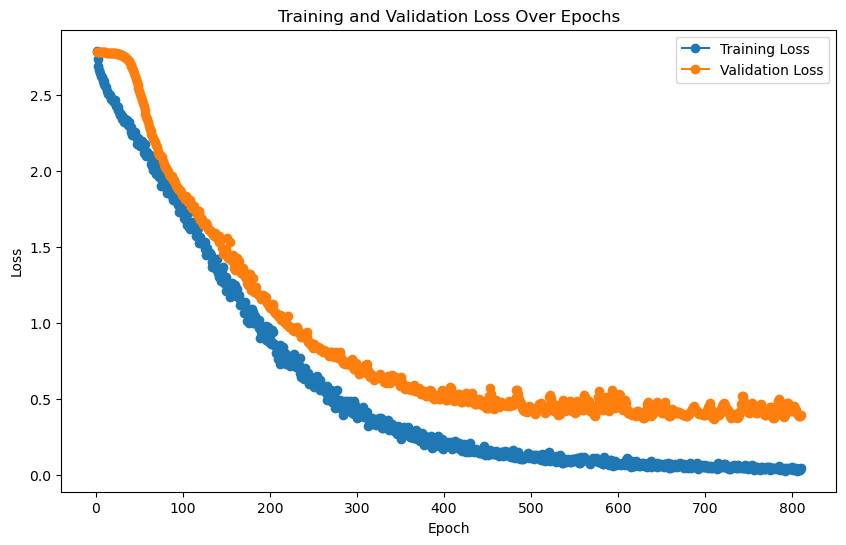

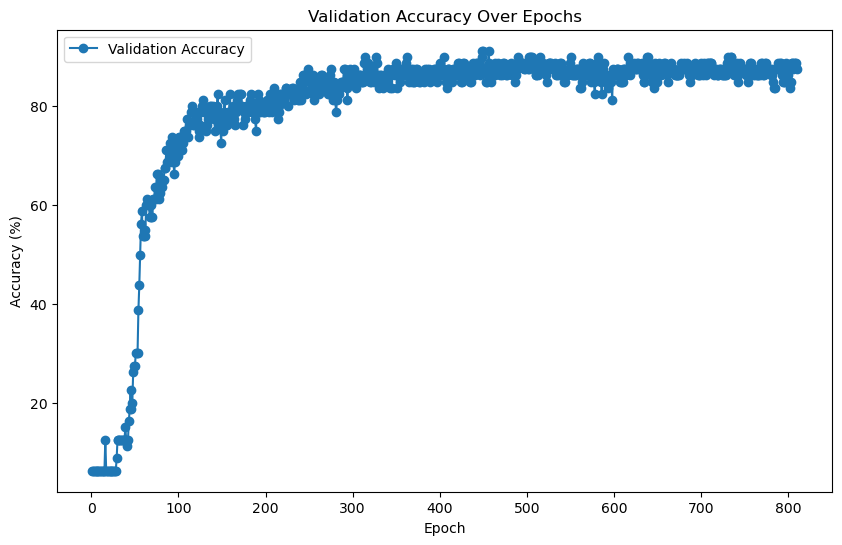


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3999



Final Test Loss: 0.6332, Test Accuracy: 82.85%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.


  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.


  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.


  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.


  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53969, 64), Test labels shape: (53969,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       0.67      0.40      0.50         5
           8       0.71      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53969, 64)
Test labels shape: (53969,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0557  |  Val Loss: 2.7871
Validation loss improved from inf to 2.7871.
[Epoch 2/1000] Train Loss: 2.7890  |  Val Loss: 2.6331
Validation loss improved from 2.7871 to 2.6331.
[Epoch 3/1000] Train Loss: 2.6624  |  Val Loss: 2.5475
Validation loss improved from 2.6331 to 2.5475.
[Epoch 4/1000] Train Loss: 2.5757  |  Val Loss: 2.4981
Validation loss improved from 2.5475 to 2.4981.
[Epoch 5/1000] Train Loss: 2.5200  |  Val Loss: 2.4517
Validation loss improved from 2.4981 to 2.4517.
[Epoch 6/1000] Train Loss: 2.4675  |  Val Loss: 2.4027
Validation loss improved from 2.4517 to 2.4027.
[Epoch 7/1000] Train Loss: 2.4179  |  Val Loss: 2.3530
Validation loss improved from 2.4027 to 2.3530.
[Epoch 8/1000] Train Loss: 2.3622  |  Val Loss: 2.3031
Validation loss improved from 2.3530 to 2.3031.
[Epoch 9/1000] Train Loss: 2.3096  |  Val Loss: 2.2598
Validation loss improved from 2.3031 to 2.2598.
[Epoch 10/1000] Train Loss: 2.2619  |  Val Loss: 2.2196
Validation loss impr

[Epoch 24/1000] Train Loss: 1.6073  |  Val Loss: 1.5832
Validation loss improved from 1.6228 to 1.5832.
[Epoch 25/1000] Train Loss: 1.5644  |  Val Loss: 1.5450
Validation loss improved from 1.5832 to 1.5450.
[Epoch 26/1000] Train Loss: 1.5258  |  Val Loss: 1.5103
Validation loss improved from 1.5450 to 1.5103.
[Epoch 27/1000] Train Loss: 1.4891  |  Val Loss: 1.4796
Validation loss improved from 1.5103 to 1.4796.
[Epoch 28/1000] Train Loss: 1.4530  |  Val Loss: 1.4445
Validation loss improved from 1.4796 to 1.4445.
[Epoch 29/1000] Train Loss: 1.4153  |  Val Loss: 1.4104
Validation loss improved from 1.4445 to 1.4104.
[Epoch 30/1000] Train Loss: 1.3790  |  Val Loss: 1.3779
Validation loss improved from 1.4104 to 1.3779.
[Epoch 31/1000] Train Loss: 1.3401  |  Val Loss: 1.3475
Validation loss improved from 1.3779 to 1.3475.
[Epoch 32/1000] Train Loss: 1.3071  |  Val Loss: 1.3173
Validation loss improved from 1.3475 to 1.3173.
[Epoch 33/1000] Train Loss: 1.2673  |  Val Loss: 1.2811
Validati

[Epoch 42/1000] Train Loss: 0.9951  |  Val Loss: 1.0475
Validation loss improved from 1.0674 to 1.0475.
[Epoch 43/1000] Train Loss: 0.9680  |  Val Loss: 1.0322
Validation loss improved from 1.0475 to 1.0322.
[Epoch 44/1000] Train Loss: 0.9423  |  Val Loss: 1.0179
Validation loss improved from 1.0322 to 1.0179.
[Epoch 45/1000] Train Loss: 0.9218  |  Val Loss: 1.0037
Validation loss improved from 1.0179 to 1.0037.
[Epoch 46/1000] Train Loss: 0.8968  |  Val Loss: 0.9788
Validation loss improved from 1.0037 to 0.9788.
[Epoch 47/1000] Train Loss: 0.8692  |  Val Loss: 0.9533
Validation loss improved from 0.9788 to 0.9533.
[Epoch 48/1000] Train Loss: 0.8511  |  Val Loss: 0.9288
Validation loss improved from 0.9533 to 0.9288.
[Epoch 49/1000] Train Loss: 0.8278  |  Val Loss: 0.9104
Validation loss improved from 0.9288 to 0.9104.
[Epoch 50/1000] Train Loss: 0.8094  |  Val Loss: 0.9072
Validation loss improved from 0.9104 to 0.9072.
[Epoch 51/1000] Train Loss: 0.7972  |  Val Loss: 0.9063
Validati

[Epoch 65/1000] Train Loss: 0.5857  |  Val Loss: 0.7365
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.5793  |  Val Loss: 0.7348
Validation loss improved from 0.7362 to 0.7348.
[Epoch 67/1000] Train Loss: 0.5663  |  Val Loss: 0.7250
Validation loss improved from 0.7348 to 0.7250.
[Epoch 68/1000] Train Loss: 0.5545  |  Val Loss: 0.7121
Validation loss improved from 0.7250 to 0.7121.
[Epoch 69/1000] Train Loss: 0.5432  |  Val Loss: 0.7021
Validation loss improved from 0.7121 to 0.7021.
[Epoch 70/1000] Train Loss: 0.5377  |  Val Loss: 0.7000
Validation loss improved from 0.7021 to 0.7000.
[Epoch 71/1000] Train Loss: 0.5377  |  Val Loss: 0.6919
Validation loss improved from 0.7000 to 0.6919.
[Epoch 72/1000] Train Loss: 0.5274  |  Val Loss: 0.6776
Validation loss improved from 0.6919 to 0.6776.
[Epoch 73/1000] Train Loss: 0.5097  |  Val Loss: 0.6656
Validation loss improved from 0.6776 to 0.6656.
[Epoch 74/1000] Train Loss: 0.5045  |  Val Loss: 0.6611
Va

[Epoch 83/1000] Train Loss: 0.4400  |  Val Loss: 0.6619
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 0.4758  |  Val Loss: 0.6750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 85/1000] Train Loss: 0.4844  |  Val Loss: 0.6565
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 0.4619  |  Val Loss: 0.6340
Validation loss improved from 0.6359 to 0.6340.
[Epoch 87/1000] Train Loss: 0.4315  |  Val Loss: 0.6117
Validation loss improved from 0.6340 to 0.6117.
[Epoch 88/1000] Train Loss: 0.4277  |  Val Loss: 0.6103
Validation loss improved from 0.6117 to 0.6103.
[Epoch 89/1000] Train Loss: 0.4293  |  Val Loss: 0.6109
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 0.4188  |  Val Loss: 0.6147
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 0.4083  |  Val Loss: 0.6259
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 

[Epoch 110/1000] Train Loss: 0.3217  |  Val Loss: 0.6143
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 111/1000] Train Loss: 0.3402  |  Val Loss: 0.6135
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 112/1000] Train Loss: 0.3384  |  Val Loss: 0.5920
Validation loss improved from 0.5980 to 0.5920.
[Epoch 113/1000] Train Loss: 0.3217  |  Val Loss: 0.5685
Validation loss improved from 0.5920 to 0.5685.
[Epoch 114/1000] Train Loss: 0.3135  |  Val Loss: 0.5628
Validation loss improved from 0.5685 to 0.5628.
[Epoch 115/1000] Train Loss: 0.3133  |  Val Loss: 0.5710
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 0.3124  |  Val Loss: 0.5882
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 0.3064  |  Val Loss: 0.5984
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 0.3027  |  Val Loss: 0.5948
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] 

[Epoch 125/1000] Train Loss: 0.2725  |  Val Loss: 0.5800
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 126/1000] Train Loss: 0.2716  |  Val Loss: 0.5846
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 127/1000] Train Loss: 0.2704  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 128/1000] Train Loss: 0.2661  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 129/1000] Train Loss: 0.2608  |  Val Loss: 0.5875
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 130/1000] Train Loss: 0.2635  |  Val Loss: 0.5737
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 131/1000] Train Loss: 0.2688  |  Val Loss: 0.5532
Validation loss improved from 0.5554 to 0.5532.
[Epoch 132/1000] Train Loss: 0.2641  |  Val Loss: 0.5435
Validation loss improved from 0.5532 to 0.5435.
[Epoch 133/1000] Train Loss: 0.2600  |  Val Loss: 0.5530
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/10

[Epoch 147/1000] Train Loss: 0.2416  |  Val Loss: 0.5671
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 148/1000] Train Loss: 0.2345  |  Val Loss: 0.5383
Validation loss improved from 0.5435 to 0.5383.
[Epoch 149/1000] Train Loss: 0.2181  |  Val Loss: 0.5247
Validation loss improved from 0.5383 to 0.5247.
[Epoch 150/1000] Train Loss: 0.2144  |  Val Loss: 0.5242
Validation loss improved from 0.5247 to 0.5242.
[Epoch 151/1000] Train Loss: 0.2185  |  Val Loss: 0.5425
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 0.2306  |  Val Loss: 0.5605
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 0.2206  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 154/1000] Train Loss: 0.2038  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 155/1000] Train Loss: 0.2205  |  Val Loss: 0.6045
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 156/1000] T

[Epoch 166/1000] Train Loss: 0.1902  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 167/1000] Train Loss: 0.1891  |  Val Loss: 0.5903
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 168/1000] Train Loss: 0.1859  |  Val Loss: 0.5667
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 169/1000] Train Loss: 0.1841  |  Val Loss: 0.5564
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 170/1000] Train Loss: 0.1877  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 171/1000] Train Loss: 0.1899  |  Val Loss: 0.5597
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 172/1000] Train Loss: 0.1872  |  Val Loss: 0.5663
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 173/1000] Train Loss: 0.1791  |  Val Loss: 0.5746
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 174/1000] Train Loss: 0.1819  |  Val Loss: 0.5802
!! Validation loss did NOT improve !! Patience:

[Epoch 190/1000] Train Loss: 0.1745  |  Val Loss: 0.6094
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 191/1000] Train Loss: 0.1784  |  Val Loss: 0.5905
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 192/1000] Train Loss: 0.1526  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 193/1000] Train Loss: 0.1513  |  Val Loss: 0.6056
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 194/1000] Train Loss: 0.1530  |  Val Loss: 0.6214
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 195/1000] Train Loss: 0.1505  |  Val Loss: 0.6399
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 196/1000] Train Loss: 0.1641  |  Val Loss: 0.6159
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 197/1000] Train Loss: 0.1529  |  Val Loss: 0.5914
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 198/1000] Train Loss: 0.1634  |  Val Loss: 0.5851
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 0.1485  |  Val Loss: 0.6216
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 208/1000] Train Loss: 0.1345  |  Val Loss: 0.5939
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 209/1000] Train Loss: 0.1498  |  Val Loss: 0.5698
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 210/1000] Train Loss: 0.1526  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 211/1000] Train Loss: 0.1539  |  Val Loss: 0.5721
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 212/1000] Train Loss: 0.1484  |  Val Loss: 0.5696
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 213/1000] Train Loss: 0.1329  |  Val Loss: 0.5840
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 214/1000] Train Loss: 0.1333  |  Val Loss: 0.6022
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 215/1000] Train Loss: 0.1375  |  Val Loss: 0.6074
!! Validation loss did NOT improve !! Patience:

[Epoch 235/1000] Train Loss: 0.1157  |  Val Loss: 0.5780
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 236/1000] Train Loss: 0.1145  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 237/1000] Train Loss: 0.1149  |  Val Loss: 0.6067
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 238/1000] Train Loss: 0.1134  |  Val Loss: 0.6249
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 239/1000] Train Loss: 0.1125  |  Val Loss: 0.6436
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 240/1000] Train Loss: 0.1142  |  Val Loss: 0.6436
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 241/1000] Train Loss: 0.1136  |  Val Loss: 0.6354
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 242/1000] Train Loss: 0.1177  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 243/1000] Train Loss: 0.1177  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience:

[Epoch 248/1000] Train Loss: 0.1063  |  Val Loss: 0.6412
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 249/1000] Train Loss: 0.1142  |  Val Loss: 0.6689
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 250/1000] Train Loss: 0.1258  |  Val Loss: 0.6801
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 250 !!
No improvement for 100 epochs.


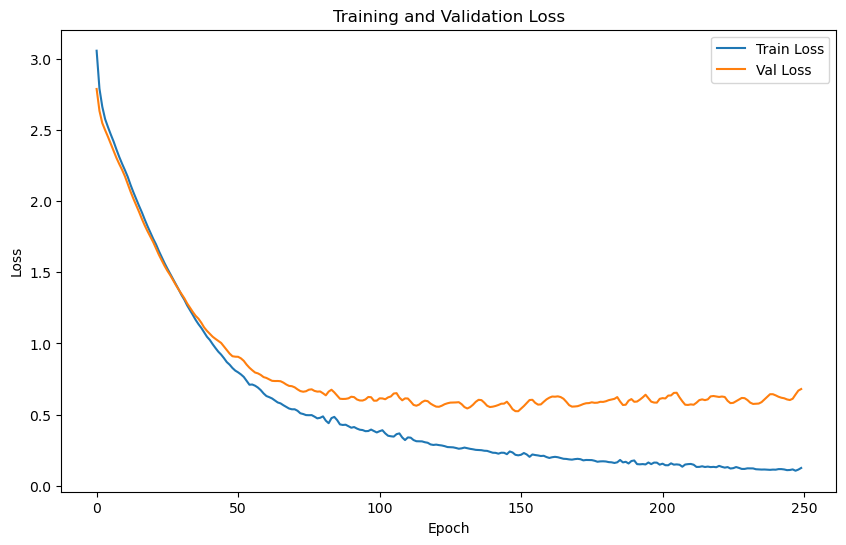

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9781 | Test Accuracy: 74.37%


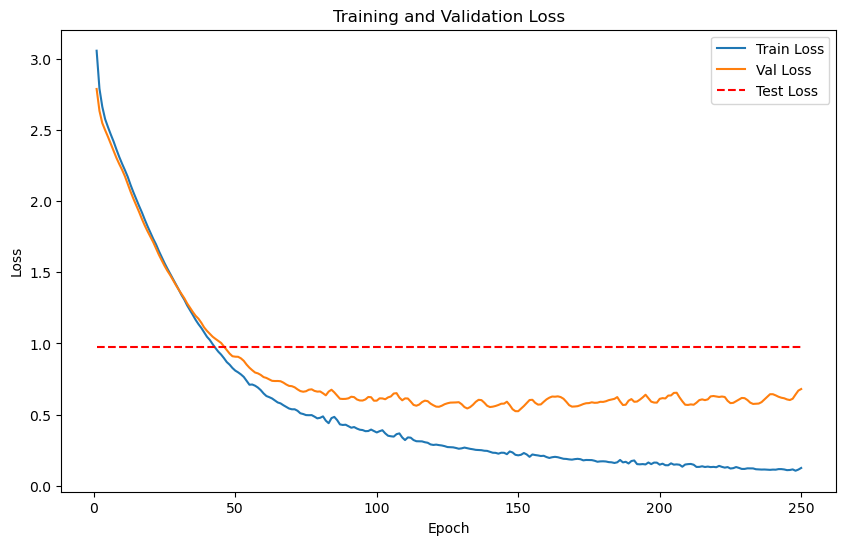

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.9863
Epoch [1/2000], Avg Train Loss: 7.9863


Epoch [1/2000], Avg Val Loss: 3.3628
Validation loss improved from inf to 3.3628. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.8707
Epoch [2/2000], Avg Train Loss: 7.8707
Epoch [2/2000], Avg Val Loss: 3.3460
Validation loss improved from 3.3628 to 3.3460. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1336
Epoch [3/2000], Avg Train Loss: 8.1336
Epoch [3/2000], Avg Val Loss: 3.3293
Validation loss improved from 3.3460 to 3.3293. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9723
Epoch [4/2000], Avg Train Loss: 7.9723
Epoch [4/2000], Avg Val Loss: 3.3131
Validation loss improved from 3.3293 to 3.3131. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9734
Epoch [5/2000], Avg Train Loss: 7.9734
Epoch [5/2000], Avg Val Loss: 3.2971
Validation loss improved from 3.3131 to 3.2971. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7875
Ep

Epoch [12/2000], Avg Val Loss: 3.1936
Validation loss improved from 3.2075 to 3.1936. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.3371
Epoch [13/2000], Avg Train Loss: 7.3371
Epoch [13/2000], Avg Val Loss: 3.1801
Validation loss improved from 3.1936 to 3.1801. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.1067
Epoch [14/2000], Avg Train Loss: 7.1067
Epoch [14/2000], Avg Val Loss: 3.1669
Validation loss improved from 3.1801 to 3.1669. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.6291
Epoch [15/2000], Avg Train Loss: 7.6291
Epoch [15/2000], Avg Val Loss: 3.1541
Validation loss improved from 3.1669 to 3.1541. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.1746
Epoch [16/2000], Avg Train Loss: 7.1746
Epoch [16/2000], Avg Val Loss: 3.1414
Validation loss improved from 3.1541 to 3.1414. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.7315
Epoch [45/2000], Avg Train Loss: 5.7315
Epoch [45/2000], Avg Val Loss: 2.9036
Validation loss improved from 2.9085 to 2.9036. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.7847
Epoch [46/2000], Avg Train Loss: 5.7847
Epoch [46/2000], Avg Val Loss: 2.8989
Validation loss improved from 2.9036 to 2.8989. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.7479
Epoch [47/2000], Avg Train Loss: 5.7479
Epoch [47/2000], Avg Val Loss: 2.8944
Validation loss improved from 2.8989 to 2.8944. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.5736
Epoch [48/2000], Avg Train Loss: 5.5736
Epoch [48/2000], Avg Val Loss: 2.8901
Validation loss improved from 2.8944 to 2.8901. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.2342
Epoch [49/2000], Avg Train Loss: 5.2342
Epoch [49/2000], Avg Val Loss: 2.8859
Validation loss improved from 2.8901 to 2.

    Batch [1/1], Train Loss: 5.0464
Epoch [59/2000], Avg Train Loss: 5.0464
Epoch [59/2000], Avg Val Loss: 2.8531
Validation loss improved from 2.8557 to 2.8531. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.2748
Epoch [60/2000], Avg Train Loss: 5.2748
Epoch [60/2000], Avg Val Loss: 2.8506
Validation loss improved from 2.8531 to 2.8506. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.2105
Epoch [61/2000], Avg Train Loss: 5.2105
Epoch [61/2000], Avg Val Loss: 2.8483
Validation loss improved from 2.8506 to 2.8483. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 4.9575
Epoch [62/2000], Avg Train Loss: 4.9575
Epoch [62/2000], Avg Val Loss: 2.8461
Validation loss improved from 2.8483 to 2.8461. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 4.9266
Epoch [63/2000], Avg Train Loss: 4.9266
Epoch [63/2000], Avg Val Loss: 2.8440
Validation loss improved from 2.8461 to 2.

    Batch [1/1], Train Loss: 4.4450
Epoch [95/2000], Avg Train Loss: 4.4450
Epoch [95/2000], Avg Val Loss: 2.8251
Validation loss did not improve. Patience: 9/100

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.1899
Epoch [96/2000], Avg Train Loss: 4.1899
Epoch [96/2000], Avg Val Loss: 2.8255
Validation loss did not improve. Patience: 10/100

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.2298
Epoch [97/2000], Avg Train Loss: 4.2298
Epoch [97/2000], Avg Val Loss: 2.8259
Validation loss did not improve. Patience: 11/100

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.1334
Epoch [98/2000], Avg Train Loss: 4.1334
Epoch [98/2000], Avg Val Loss: 2.8263
Validation loss did not improve. Patience: 12/100

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.1885
Epoch [99/2000], Avg Train Loss: 4.1885
Epoch [99/2000], Avg Val Loss: 2.8267
Validation loss did not improve. Patience: 13/100

LOG: Epoch [100/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.0940
Epoch [107/2000], Avg Train Loss: 4.0940
Epoch [107/2000], Avg Val Loss: 2.8301
Validation loss did not improve. Patience: 21/100

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 3.9971
Epoch [108/2000], Avg Train Loss: 3.9971
Epoch [108/2000], Avg Val Loss: 2.8306
Validation loss did not improve. Patience: 22/100

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.0422
Epoch [109/2000], Avg Train Loss: 4.0422
Epoch [109/2000], Avg Val Loss: 2.8310
Validation loss did not improve. Patience: 23/100

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.1972
Epoch [110/2000], Avg Train Loss: 4.1972
Epoch [110/2000], Avg Val Loss: 2.8314
Validation loss did not improve. Patience: 24/100

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.1224
Epoch [111/2000], Avg Train Loss: 4.1224
Epoch [111/2000], Avg Val Loss: 2.8319
Validation loss did not improve. Patience: 25/100

LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 3.7504
Epoch [142/2000], Avg Train Loss: 3.7504
Epoch [142/2000], Avg Val Loss: 2.8467
Validation loss did not improve. Patience: 56/100

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 3.6350
Epoch [143/2000], Avg Train Loss: 3.6350
Epoch [143/2000], Avg Val Loss: 2.8471
Validation loss did not improve. Patience: 57/100

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 3.8227
Epoch [144/2000], Avg Train Loss: 3.8227
Epoch [144/2000], Avg Val Loss: 2.8474
Validation loss did not improve. Patience: 58/100

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.6798
Epoch [145/2000], Avg Train Loss: 3.6798
Epoch [145/2000], Avg Val Loss: 2.8477
Validation loss did not improve. Patience: 59/100

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 3.7441
Epoch [146/2000], Avg Train Loss: 3.7441
Epoch [146/2000], Avg Val Loss: 2.8480
Validation loss did not improve. Patience: 60/100

LOG: Epoch [147/2000] - Training


Epoch [156/2000], Avg Val Loss: 2.8502
Validation loss did not improve. Patience: 70/100

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 3.6055
Epoch [157/2000], Avg Train Loss: 3.6055
Epoch [157/2000], Avg Val Loss: 2.8504
Validation loss did not improve. Patience: 71/100

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 3.6338
Epoch [158/2000], Avg Train Loss: 3.6338
Epoch [158/2000], Avg Val Loss: 2.8505
Validation loss did not improve. Patience: 72/100

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 3.5767
Epoch [159/2000], Avg Train Loss: 3.5767
Epoch [159/2000], Avg Val Loss: 2.8507
Validation loss did not improve. Patience: 73/100

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.7961
Epoch [160/2000], Avg Train Loss: 3.7961
Epoch [160/2000], Avg Val Loss: 2.8509
Validation loss did not improve. Patience: 74/100

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.7761
Epoch [161/2000], Avg Train Loss: 3.7761


Epoch [185/2000], Avg Val Loss: 2.8539
Validation loss did not improve. Patience: 99/100

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 3.6466
Epoch [186/2000], Avg Train Loss: 3.6466
Epoch [186/2000], Avg Val Loss: 2.8539
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 186. No improvement for 100 epochs.


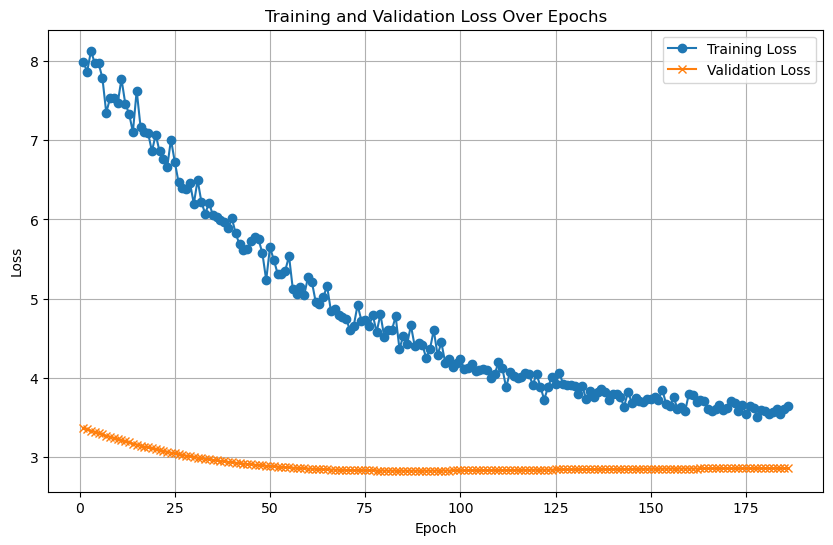

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 5.0957
Test Batch [20/211], Loss: 5.1957
Test Batch [30/211], Loss: 5.2614
Test Batch [40/211], Loss: 5.1855
Test Batch [50/211], Loss: 4.5007
Test Batch [60/211], Loss: 4.7353
Test Batch [70/211], Loss: 4.9105


Test Batch [80/211], Loss: 5.1629
Test Batch [90/211], Loss: 4.5547
Test Batch [100/211], Loss: 4.6418
Test Batch [110/211], Loss: 4.6797
Test Batch [120/211], Loss: 4.7262
Test Batch [130/211], Loss: 5.2465
Test Batch [140/211], Loss: 5.3185
Test Batch [150/211], Loss: 5.1530
Test Batch [160/211], Loss: 5.0147


Test Batch [170/211], Loss: 5.3620
Test Batch [180/211], Loss: 5.2426
Test Batch [190/211], Loss: 5.1972
Test Batch [200/211], Loss: 5.1208
Test Batch [210/211], Loss: 5.1172

Test Loss: 5.0196


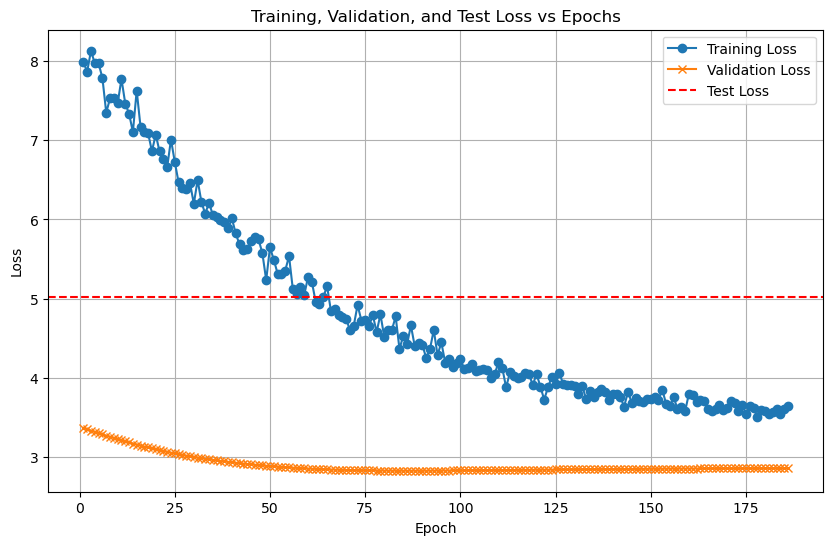

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.


  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.


  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 83.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       0.67      0.40      0.50         5
           8       0.71      1.00      0.83         5
           9       0.71      1.00      0.83         5
          10       0.67      0.40      0.50         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8365  |  Val Loss: 2.8472
Validation loss improved from inf to 2.8472.
[Epoch 2/1000] Train Loss: 2.8250  |  Val Loss: 2.8378
Validation loss improved from 2.8472 to 2.8378.
[Epoch 3/1000] Train Loss: 2.8159  |  Val Loss: 2.8287
Validation loss improved from 2.8378 to 2.8287.
[Epoch 4/1000] Train Loss: 2.8065  |  Val Loss: 2.8204
Validation loss improved from 2.8287 to 2.8204.
[Epoch 5/1000] Train Loss: 2.7976  |  Val Loss: 2.8123
Validation loss improved from 2.8204 to 2.8123.
[Epoch 6/1000] Train Loss: 2.7899  |  Val Loss: 2.8042
Validation loss improved from 2.8123 to 2.8042.
[Epoch 7/1000] Train Loss: 2.7819  |  Val Loss: 2.7965
Validation loss improved from 2.8042 to 2.7965.
[Epoch 8/1000] Train Loss: 2.7743  |  Val Loss: 2.7890
Validation loss improved from 2.7965 to 2.7890.
[Epoch 9/1000] Train Loss: 2.7665  |  Val Loss: 2.7815
Validation loss improved from 2.7890 to 2.7815.
[Epoch 10/1000] Train Loss: 2.7592  |  Val Loss: 2.7739
Validation loss impr

[Epoch 35/1000] Train Loss: 2.6037  |  Val Loss: 2.6232
Validation loss improved from 2.6295 to 2.6232.
[Epoch 36/1000] Train Loss: 2.5975  |  Val Loss: 2.6171
Validation loss improved from 2.6232 to 2.6171.
[Epoch 37/1000] Train Loss: 2.5914  |  Val Loss: 2.6112
Validation loss improved from 2.6171 to 2.6112.
[Epoch 38/1000] Train Loss: 2.5853  |  Val Loss: 2.6055
Validation loss improved from 2.6112 to 2.6055.
[Epoch 39/1000] Train Loss: 2.5790  |  Val Loss: 2.5998
Validation loss improved from 2.6055 to 2.5998.
[Epoch 40/1000] Train Loss: 2.5734  |  Val Loss: 2.5941
Validation loss improved from 2.5998 to 2.5941.
[Epoch 41/1000] Train Loss: 2.5676  |  Val Loss: 2.5884
Validation loss improved from 2.5941 to 2.5884.
[Epoch 42/1000] Train Loss: 2.5618  |  Val Loss: 2.5826
Validation loss improved from 2.5884 to 2.5826.
[Epoch 43/1000] Train Loss: 2.5562  |  Val Loss: 2.5769
Validation loss improved from 2.5826 to 2.5769.


[Epoch 44/1000] Train Loss: 2.5504  |  Val Loss: 2.5712
Validation loss improved from 2.5769 to 2.5712.
[Epoch 45/1000] Train Loss: 2.5445  |  Val Loss: 2.5657
Validation loss improved from 2.5712 to 2.5657.
[Epoch 46/1000] Train Loss: 2.5385  |  Val Loss: 2.5601
Validation loss improved from 2.5657 to 2.5601.
[Epoch 47/1000] Train Loss: 2.5323  |  Val Loss: 2.5544
Validation loss improved from 2.5601 to 2.5544.
[Epoch 48/1000] Train Loss: 2.5267  |  Val Loss: 2.5485
Validation loss improved from 2.5544 to 2.5485.
[Epoch 49/1000] Train Loss: 2.5206  |  Val Loss: 2.5426
Validation loss improved from 2.5485 to 2.5426.
[Epoch 50/1000] Train Loss: 2.5145  |  Val Loss: 2.5367
Validation loss improved from 2.5426 to 2.5367.
[Epoch 51/1000] Train Loss: 2.5085  |  Val Loss: 2.5308
Validation loss improved from 2.5367 to 2.5308.
[Epoch 52/1000] Train Loss: 2.5025  |  Val Loss: 2.5250
Validation loss improved from 2.5308 to 2.5250.
[Epoch 53/1000] Train Loss: 2.4964  |  Val Loss: 2.5193
Validati

[Epoch 77/1000] Train Loss: 2.3603  |  Val Loss: 2.3924
Validation loss improved from 2.3973 to 2.3924.
[Epoch 78/1000] Train Loss: 2.3551  |  Val Loss: 2.3877
Validation loss improved from 2.3924 to 2.3877.
[Epoch 79/1000] Train Loss: 2.3496  |  Val Loss: 2.3829
Validation loss improved from 2.3877 to 2.3829.
[Epoch 80/1000] Train Loss: 2.3445  |  Val Loss: 2.3782
Validation loss improved from 2.3829 to 2.3782.
[Epoch 81/1000] Train Loss: 2.3393  |  Val Loss: 2.3736
Validation loss improved from 2.3782 to 2.3736.
[Epoch 82/1000] Train Loss: 2.3342  |  Val Loss: 2.3688
Validation loss improved from 2.3736 to 2.3688.
[Epoch 83/1000] Train Loss: 2.3291  |  Val Loss: 2.3640
Validation loss improved from 2.3688 to 2.3640.
[Epoch 84/1000] Train Loss: 2.3239  |  Val Loss: 2.3591
Validation loss improved from 2.3640 to 2.3591.
[Epoch 85/1000] Train Loss: 2.3183  |  Val Loss: 2.3543
Validation loss improved from 2.3591 to 2.3543.
[Epoch 86/1000] Train Loss: 2.3133  |  Val Loss: 2.3495
Validati

[Epoch 88/1000] Train Loss: 2.3027  |  Val Loss: 2.3396
Validation loss improved from 2.3445 to 2.3396.
[Epoch 89/1000] Train Loss: 2.2973  |  Val Loss: 2.3348
Validation loss improved from 2.3396 to 2.3348.
[Epoch 90/1000] Train Loss: 2.2920  |  Val Loss: 2.3300
Validation loss improved from 2.3348 to 2.3300.
[Epoch 91/1000] Train Loss: 2.2867  |  Val Loss: 2.3254
Validation loss improved from 2.3300 to 2.3254.
[Epoch 92/1000] Train Loss: 2.2816  |  Val Loss: 2.3206
Validation loss improved from 2.3254 to 2.3206.
[Epoch 93/1000] Train Loss: 2.2763  |  Val Loss: 2.3155
Validation loss improved from 2.3206 to 2.3155.
[Epoch 94/1000] Train Loss: 2.2708  |  Val Loss: 2.3102
Validation loss improved from 2.3155 to 2.3102.
[Epoch 95/1000] Train Loss: 2.2653  |  Val Loss: 2.3047
Validation loss improved from 2.3102 to 2.3047.
[Epoch 96/1000] Train Loss: 2.2597  |  Val Loss: 2.2992
Validation loss improved from 2.3047 to 2.2992.
[Epoch 97/1000] Train Loss: 2.2539  |  Val Loss: 2.2937
Validati

[Epoch 117/1000] Train Loss: 2.1433  |  Val Loss: 2.1863
Validation loss improved from 2.1912 to 2.1863.
[Epoch 118/1000] Train Loss: 2.1379  |  Val Loss: 2.1815
Validation loss improved from 2.1863 to 2.1815.
[Epoch 119/1000] Train Loss: 2.1323  |  Val Loss: 2.1767
Validation loss improved from 2.1815 to 2.1767.
[Epoch 120/1000] Train Loss: 2.1269  |  Val Loss: 2.1718
Validation loss improved from 2.1767 to 2.1718.
[Epoch 121/1000] Train Loss: 2.1219  |  Val Loss: 2.1667
Validation loss improved from 2.1718 to 2.1667.
[Epoch 122/1000] Train Loss: 2.1165  |  Val Loss: 2.1614
Validation loss improved from 2.1667 to 2.1614.
[Epoch 123/1000] Train Loss: 2.1111  |  Val Loss: 2.1559
Validation loss improved from 2.1614 to 2.1559.
[Epoch 124/1000] Train Loss: 2.1058  |  Val Loss: 2.1504
Validation loss improved from 2.1559 to 2.1504.
[Epoch 125/1000] Train Loss: 2.1003  |  Val Loss: 2.1453
Validation loss improved from 2.1504 to 2.1453.


[Epoch 126/1000] Train Loss: 2.0953  |  Val Loss: 2.1403
Validation loss improved from 2.1453 to 2.1403.
[Epoch 127/1000] Train Loss: 2.0899  |  Val Loss: 2.1354
Validation loss improved from 2.1403 to 2.1354.
[Epoch 128/1000] Train Loss: 2.0847  |  Val Loss: 2.1303
Validation loss improved from 2.1354 to 2.1303.
[Epoch 129/1000] Train Loss: 2.0792  |  Val Loss: 2.1253
Validation loss improved from 2.1303 to 2.1253.
[Epoch 130/1000] Train Loss: 2.0738  |  Val Loss: 2.1201
Validation loss improved from 2.1253 to 2.1201.
[Epoch 131/1000] Train Loss: 2.0684  |  Val Loss: 2.1149
Validation loss improved from 2.1201 to 2.1149.
[Epoch 132/1000] Train Loss: 2.0631  |  Val Loss: 2.1097
Validation loss improved from 2.1149 to 2.1097.
[Epoch 133/1000] Train Loss: 2.0581  |  Val Loss: 2.1046
Validation loss improved from 2.1097 to 2.1046.
[Epoch 134/1000] Train Loss: 2.0528  |  Val Loss: 2.0994
Validation loss improved from 2.1046 to 2.0994.
[Epoch 135/1000] Train Loss: 2.0477  |  Val Loss: 2.094

[Epoch 152/1000] Train Loss: 1.9574  |  Val Loss: 2.0059
Validation loss improved from 2.0109 to 2.0059.
[Epoch 153/1000] Train Loss: 1.9521  |  Val Loss: 2.0011
Validation loss improved from 2.0059 to 2.0011.
[Epoch 154/1000] Train Loss: 1.9471  |  Val Loss: 1.9964
Validation loss improved from 2.0011 to 1.9964.
[Epoch 155/1000] Train Loss: 1.9417  |  Val Loss: 1.9917
Validation loss improved from 1.9964 to 1.9917.
[Epoch 156/1000] Train Loss: 1.9365  |  Val Loss: 1.9872
Validation loss improved from 1.9917 to 1.9872.
[Epoch 157/1000] Train Loss: 1.9313  |  Val Loss: 1.9824
Validation loss improved from 1.9872 to 1.9824.
[Epoch 158/1000] Train Loss: 1.9263  |  Val Loss: 1.9774
Validation loss improved from 1.9824 to 1.9774.
[Epoch 159/1000] Train Loss: 1.9213  |  Val Loss: 1.9722
Validation loss improved from 1.9774 to 1.9722.
[Epoch 160/1000] Train Loss: 1.9162  |  Val Loss: 1.9670
Validation loss improved from 1.9722 to 1.9670.
[Epoch 161/1000] Train Loss: 1.9112  |  Val Loss: 1.962

[Epoch 166/1000] Train Loss: 1.8854  |  Val Loss: 1.9388
Validation loss improved from 1.9437 to 1.9388.
[Epoch 167/1000] Train Loss: 1.8802  |  Val Loss: 1.9339
Validation loss improved from 1.9388 to 1.9339.
[Epoch 168/1000] Train Loss: 1.8751  |  Val Loss: 1.9291
Validation loss improved from 1.9339 to 1.9291.
[Epoch 169/1000] Train Loss: 1.8698  |  Val Loss: 1.9241
Validation loss improved from 1.9291 to 1.9241.
[Epoch 170/1000] Train Loss: 1.8646  |  Val Loss: 1.9190
Validation loss improved from 1.9241 to 1.9190.
[Epoch 171/1000] Train Loss: 1.8597  |  Val Loss: 1.9138
Validation loss improved from 1.9190 to 1.9138.
[Epoch 172/1000] Train Loss: 1.8545  |  Val Loss: 1.9087
Validation loss improved from 1.9138 to 1.9087.
[Epoch 173/1000] Train Loss: 1.8494  |  Val Loss: 1.9036
Validation loss improved from 1.9087 to 1.9036.
[Epoch 174/1000] Train Loss: 1.8443  |  Val Loss: 1.8984
Validation loss improved from 1.9036 to 1.8984.
[Epoch 175/1000] Train Loss: 1.8394  |  Val Loss: 1.893

[Epoch 196/1000] Train Loss: 1.7308  |  Val Loss: 1.7896
Validation loss improved from 1.7944 to 1.7896.
[Epoch 197/1000] Train Loss: 1.7260  |  Val Loss: 1.7851
Validation loss improved from 1.7896 to 1.7851.
[Epoch 198/1000] Train Loss: 1.7209  |  Val Loss: 1.7808
Validation loss improved from 1.7851 to 1.7808.
[Epoch 199/1000] Train Loss: 1.7159  |  Val Loss: 1.7765
Validation loss improved from 1.7808 to 1.7765.
[Epoch 200/1000] Train Loss: 1.7109  |  Val Loss: 1.7722
Validation loss improved from 1.7765 to 1.7722.
[Epoch 201/1000] Train Loss: 1.7059  |  Val Loss: 1.7679
Validation loss improved from 1.7722 to 1.7679.
[Epoch 202/1000] Train Loss: 1.7010  |  Val Loss: 1.7635
Validation loss improved from 1.7679 to 1.7635.
[Epoch 203/1000] Train Loss: 1.6960  |  Val Loss: 1.7588
Validation loss improved from 1.7635 to 1.7588.
[Epoch 204/1000] Train Loss: 1.6911  |  Val Loss: 1.7540
Validation loss improved from 1.7588 to 1.7540.
[Epoch 205/1000] Train Loss: 1.6859  |  Val Loss: 1.749

[Epoch 208/1000] Train Loss: 1.6709  |  Val Loss: 1.7351
Validation loss improved from 1.7399 to 1.7351.
[Epoch 209/1000] Train Loss: 1.6659  |  Val Loss: 1.7302
Validation loss improved from 1.7351 to 1.7302.
[Epoch 210/1000] Train Loss: 1.6606  |  Val Loss: 1.7254
Validation loss improved from 1.7302 to 1.7254.
[Epoch 211/1000] Train Loss: 1.6559  |  Val Loss: 1.7209
Validation loss improved from 1.7254 to 1.7209.
[Epoch 212/1000] Train Loss: 1.6509  |  Val Loss: 1.7165
Validation loss improved from 1.7209 to 1.7165.
[Epoch 213/1000] Train Loss: 1.6457  |  Val Loss: 1.7122
Validation loss improved from 1.7165 to 1.7122.
[Epoch 214/1000] Train Loss: 1.6409  |  Val Loss: 1.7080
Validation loss improved from 1.7122 to 1.7080.
[Epoch 215/1000] Train Loss: 1.6362  |  Val Loss: 1.7039
Validation loss improved from 1.7080 to 1.7039.
[Epoch 216/1000] Train Loss: 1.6314  |  Val Loss: 1.6997
Validation loss improved from 1.7039 to 1.6997.
[Epoch 217/1000] Train Loss: 1.6269  |  Val Loss: 1.695

[Epoch 239/1000] Train Loss: 1.5244  |  Val Loss: 1.6000
Validation loss improved from 1.6041 to 1.6000.
[Epoch 240/1000] Train Loss: 1.5198  |  Val Loss: 1.5958
Validation loss improved from 1.6000 to 1.5958.
[Epoch 241/1000] Train Loss: 1.5155  |  Val Loss: 1.5917
Validation loss improved from 1.5958 to 1.5917.
[Epoch 242/1000] Train Loss: 1.5109  |  Val Loss: 1.5878
Validation loss improved from 1.5917 to 1.5878.
[Epoch 243/1000] Train Loss: 1.5068  |  Val Loss: 1.5837
Validation loss improved from 1.5878 to 1.5837.
[Epoch 244/1000] Train Loss: 1.5023  |  Val Loss: 1.5796
Validation loss improved from 1.5837 to 1.5796.
[Epoch 245/1000] Train Loss: 1.4977  |  Val Loss: 1.5755
Validation loss improved from 1.5796 to 1.5755.
[Epoch 246/1000] Train Loss: 1.4933  |  Val Loss: 1.5714
Validation loss improved from 1.5755 to 1.5714.
[Epoch 247/1000] Train Loss: 1.4886  |  Val Loss: 1.5674
Validation loss improved from 1.5714 to 1.5674.
[Epoch 248/1000] Train Loss: 1.4842  |  Val Loss: 1.563

[Epoch 252/1000] Train Loss: 1.4663  |  Val Loss: 1.5484
Validation loss improved from 1.5525 to 1.5484.
[Epoch 253/1000] Train Loss: 1.4616  |  Val Loss: 1.5440
Validation loss improved from 1.5484 to 1.5440.
[Epoch 254/1000] Train Loss: 1.4569  |  Val Loss: 1.5393
Validation loss improved from 1.5440 to 1.5393.
[Epoch 255/1000] Train Loss: 1.4523  |  Val Loss: 1.5346
Validation loss improved from 1.5393 to 1.5346.
[Epoch 256/1000] Train Loss: 1.4476  |  Val Loss: 1.5300
Validation loss improved from 1.5346 to 1.5300.
[Epoch 257/1000] Train Loss: 1.4441  |  Val Loss: 1.5254
Validation loss improved from 1.5300 to 1.5254.
[Epoch 258/1000] Train Loss: 1.4398  |  Val Loss: 1.5209
Validation loss improved from 1.5254 to 1.5209.
[Epoch 259/1000] Train Loss: 1.4352  |  Val Loss: 1.5165
Validation loss improved from 1.5209 to 1.5165.
[Epoch 260/1000] Train Loss: 1.4309  |  Val Loss: 1.5121
Validation loss improved from 1.5165 to 1.5121.
[Epoch 261/1000] Train Loss: 1.4258  |  Val Loss: 1.507

[Epoch 282/1000] Train Loss: 1.3329  |  Val Loss: 1.4262
Validation loss improved from 1.4302 to 1.4262.
[Epoch 283/1000] Train Loss: 1.3284  |  Val Loss: 1.4221
Validation loss improved from 1.4262 to 1.4221.
[Epoch 284/1000] Train Loss: 1.3239  |  Val Loss: 1.4182
Validation loss improved from 1.4221 to 1.4182.
[Epoch 285/1000] Train Loss: 1.3197  |  Val Loss: 1.4143
Validation loss improved from 1.4182 to 1.4143.
[Epoch 286/1000] Train Loss: 1.3154  |  Val Loss: 1.4106
Validation loss improved from 1.4143 to 1.4106.
[Epoch 287/1000] Train Loss: 1.3110  |  Val Loss: 1.4071
Validation loss improved from 1.4106 to 1.4071.
[Epoch 288/1000] Train Loss: 1.3066  |  Val Loss: 1.4036
Validation loss improved from 1.4071 to 1.4036.
[Epoch 289/1000] Train Loss: 1.3023  |  Val Loss: 1.4002
Validation loss improved from 1.4036 to 1.4002.


[Epoch 290/1000] Train Loss: 1.2982  |  Val Loss: 1.3966
Validation loss improved from 1.4002 to 1.3966.
[Epoch 291/1000] Train Loss: 1.2943  |  Val Loss: 1.3929
Validation loss improved from 1.3966 to 1.3929.
[Epoch 292/1000] Train Loss: 1.2901  |  Val Loss: 1.3889
Validation loss improved from 1.3929 to 1.3889.
[Epoch 293/1000] Train Loss: 1.2857  |  Val Loss: 1.3849
Validation loss improved from 1.3889 to 1.3849.
[Epoch 294/1000] Train Loss: 1.2818  |  Val Loss: 1.3809
Validation loss improved from 1.3849 to 1.3809.
[Epoch 295/1000] Train Loss: 1.2775  |  Val Loss: 1.3769
Validation loss improved from 1.3809 to 1.3769.
[Epoch 296/1000] Train Loss: 1.2729  |  Val Loss: 1.3729
Validation loss improved from 1.3769 to 1.3729.
[Epoch 297/1000] Train Loss: 1.2688  |  Val Loss: 1.3689
Validation loss improved from 1.3729 to 1.3689.
[Epoch 298/1000] Train Loss: 1.2648  |  Val Loss: 1.3648
Validation loss improved from 1.3689 to 1.3648.
[Epoch 299/1000] Train Loss: 1.2601  |  Val Loss: 1.360

[Epoch 325/1000] Train Loss: 1.1551  |  Val Loss: 1.2707
Validation loss improved from 1.2741 to 1.2707.
[Epoch 326/1000] Train Loss: 1.1505  |  Val Loss: 1.2670
Validation loss improved from 1.2707 to 1.2670.
[Epoch 327/1000] Train Loss: 1.1462  |  Val Loss: 1.2631
Validation loss improved from 1.2670 to 1.2631.
[Epoch 328/1000] Train Loss: 1.1417  |  Val Loss: 1.2593
Validation loss improved from 1.2631 to 1.2593.
[Epoch 329/1000] Train Loss: 1.1370  |  Val Loss: 1.2554
Validation loss improved from 1.2593 to 1.2554.
[Epoch 330/1000] Train Loss: 1.1327  |  Val Loss: 1.2515
Validation loss improved from 1.2554 to 1.2515.
[Epoch 331/1000] Train Loss: 1.1287  |  Val Loss: 1.2478
Validation loss improved from 1.2515 to 1.2478.
[Epoch 332/1000] Train Loss: 1.1242  |  Val Loss: 1.2446
Validation loss improved from 1.2478 to 1.2446.
[Epoch 333/1000] Train Loss: 1.1201  |  Val Loss: 1.2416
Validation loss improved from 1.2446 to 1.2416.
[Epoch 334/1000] Train Loss: 1.1164  |  Val Loss: 1.238

[Epoch 365/1000] Train Loss: 0.9914  |  Val Loss: 1.1278
Validation loss improved from 1.1314 to 1.1278.
[Epoch 366/1000] Train Loss: 0.9876  |  Val Loss: 1.1241
Validation loss improved from 1.1278 to 1.1241.
[Epoch 367/1000] Train Loss: 0.9840  |  Val Loss: 1.1204
Validation loss improved from 1.1241 to 1.1204.
[Epoch 368/1000] Train Loss: 0.9801  |  Val Loss: 1.1165
Validation loss improved from 1.1204 to 1.1165.
[Epoch 369/1000] Train Loss: 0.9764  |  Val Loss: 1.1127
Validation loss improved from 1.1165 to 1.1127.
[Epoch 370/1000] Train Loss: 0.9726  |  Val Loss: 1.1089
Validation loss improved from 1.1127 to 1.1089.
[Epoch 371/1000] Train Loss: 0.9688  |  Val Loss: 1.1053
Validation loss improved from 1.1089 to 1.1053.
[Epoch 372/1000] Train Loss: 0.9651  |  Val Loss: 1.1020
Validation loss improved from 1.1053 to 1.1020.
[Epoch 373/1000] Train Loss: 0.9611  |  Val Loss: 1.0988
Validation loss improved from 1.1020 to 1.0988.
[Epoch 374/1000] Train Loss: 0.9575  |  Val Loss: 1.095

[Epoch 408/1000] Train Loss: 0.8461  |  Val Loss: 0.9888
Validation loss improved from 0.9914 to 0.9888.
[Epoch 409/1000] Train Loss: 0.8429  |  Val Loss: 0.9863
Validation loss improved from 0.9888 to 0.9863.
[Epoch 410/1000] Train Loss: 0.8402  |  Val Loss: 0.9843
Validation loss improved from 0.9863 to 0.9843.
[Epoch 411/1000] Train Loss: 0.8375  |  Val Loss: 0.9827
Validation loss improved from 0.9843 to 0.9827.
[Epoch 412/1000] Train Loss: 0.8344  |  Val Loss: 0.9816
Validation loss improved from 0.9827 to 0.9816.
[Epoch 413/1000] Train Loss: 0.8323  |  Val Loss: 0.9803
Validation loss improved from 0.9816 to 0.9803.
[Epoch 414/1000] Train Loss: 0.8294  |  Val Loss: 0.9784
Validation loss improved from 0.9803 to 0.9784.
[Epoch 415/1000] Train Loss: 0.8263  |  Val Loss: 0.9763
Validation loss improved from 0.9784 to 0.9763.
[Epoch 416/1000] Train Loss: 0.8234  |  Val Loss: 0.9735
Validation loss improved from 0.9763 to 0.9735.
[Epoch 417/1000] Train Loss: 0.8208  |  Val Loss: 0.970

[Epoch 451/1000] Train Loss: 0.7406  |  Val Loss: 0.8906
Validation loss improved from 0.8924 to 0.8906.
[Epoch 452/1000] Train Loss: 0.7381  |  Val Loss: 0.8889
Validation loss improved from 0.8906 to 0.8889.
[Epoch 453/1000] Train Loss: 0.7358  |  Val Loss: 0.8879
Validation loss improved from 0.8889 to 0.8879.
[Epoch 454/1000] Train Loss: 0.7340  |  Val Loss: 0.8870
Validation loss improved from 0.8879 to 0.8870.
[Epoch 455/1000] Train Loss: 0.7315  |  Val Loss: 0.8855
Validation loss improved from 0.8870 to 0.8855.
[Epoch 456/1000] Train Loss: 0.7297  |  Val Loss: 0.8845
Validation loss improved from 0.8855 to 0.8845.
[Epoch 457/1000] Train Loss: 0.7276  |  Val Loss: 0.8842
Validation loss improved from 0.8845 to 0.8842.
[Epoch 458/1000] Train Loss: 0.7259  |  Val Loss: 0.8836
Validation loss improved from 0.8842 to 0.8836.
[Epoch 459/1000] Train Loss: 0.7238  |  Val Loss: 0.8827
Validation loss improved from 0.8836 to 0.8827.
[Epoch 460/1000] Train Loss: 0.7223  |  Val Loss: 0.881

[Epoch 490/1000] Train Loss: 0.6698  |  Val Loss: 0.8365
Validation loss improved from 0.8380 to 0.8365.
[Epoch 491/1000] Train Loss: 0.6680  |  Val Loss: 0.8349
Validation loss improved from 0.8365 to 0.8349.
[Epoch 492/1000] Train Loss: 0.6663  |  Val Loss: 0.8328
Validation loss improved from 0.8349 to 0.8328.
[Epoch 493/1000] Train Loss: 0.6645  |  Val Loss: 0.8303
Validation loss improved from 0.8328 to 0.8303.
[Epoch 494/1000] Train Loss: 0.6629  |  Val Loss: 0.8276
Validation loss improved from 0.8303 to 0.8276.
[Epoch 495/1000] Train Loss: 0.6611  |  Val Loss: 0.8248
Validation loss improved from 0.8276 to 0.8248.
[Epoch 496/1000] Train Loss: 0.6588  |  Val Loss: 0.8221
Validation loss improved from 0.8248 to 0.8221.
[Epoch 497/1000] Train Loss: 0.6573  |  Val Loss: 0.8199
Validation loss improved from 0.8221 to 0.8199.
[Epoch 498/1000] Train Loss: 0.6556  |  Val Loss: 0.8189
Validation loss improved from 0.8199 to 0.8189.
[Epoch 499/1000] Train Loss: 0.6540  |  Val Loss: 0.818

[Epoch 529/1000] Train Loss: 0.6116  |  Val Loss: 0.7803
Validation loss improved from 0.7824 to 0.7803.
[Epoch 530/1000] Train Loss: 0.6107  |  Val Loss: 0.7783
Validation loss improved from 0.7803 to 0.7783.
[Epoch 531/1000] Train Loss: 0.6094  |  Val Loss: 0.7760
Validation loss improved from 0.7783 to 0.7760.
[Epoch 532/1000] Train Loss: 0.6080  |  Val Loss: 0.7741
Validation loss improved from 0.7760 to 0.7741.
[Epoch 533/1000] Train Loss: 0.6065  |  Val Loss: 0.7727
Validation loss improved from 0.7741 to 0.7727.
[Epoch 534/1000] Train Loss: 0.6062  |  Val Loss: 0.7714
Validation loss improved from 0.7727 to 0.7714.
[Epoch 535/1000] Train Loss: 0.6045  |  Val Loss: 0.7706
Validation loss improved from 0.7714 to 0.7706.
[Epoch 536/1000] Train Loss: 0.6027  |  Val Loss: 0.7694
Validation loss improved from 0.7706 to 0.7694.
[Epoch 537/1000] Train Loss: 0.6015  |  Val Loss: 0.7682
Validation loss improved from 0.7694 to 0.7682.
[Epoch 538/1000] Train Loss: 0.6002  |  Val Loss: 0.767

[Epoch 567/1000] Train Loss: 0.5658  |  Val Loss: 0.7455
Validation loss improved from 0.7463 to 0.7455.
[Epoch 568/1000] Train Loss: 0.5648  |  Val Loss: 0.7440
Validation loss improved from 0.7455 to 0.7440.
[Epoch 569/1000] Train Loss: 0.5639  |  Val Loss: 0.7425
Validation loss improved from 0.7440 to 0.7425.
[Epoch 570/1000] Train Loss: 0.5631  |  Val Loss: 0.7411
Validation loss improved from 0.7425 to 0.7411.
[Epoch 571/1000] Train Loss: 0.5622  |  Val Loss: 0.7399
Validation loss improved from 0.7411 to 0.7399.
[Epoch 572/1000] Train Loss: 0.5610  |  Val Loss: 0.7392
Validation loss improved from 0.7399 to 0.7392.
[Epoch 573/1000] Train Loss: 0.5596  |  Val Loss: 0.7382
Validation loss improved from 0.7392 to 0.7382.
[Epoch 574/1000] Train Loss: 0.5578  |  Val Loss: 0.7369
Validation loss improved from 0.7382 to 0.7369.
[Epoch 575/1000] Train Loss: 0.5565  |  Val Loss: 0.7353
Validation loss improved from 0.7369 to 0.7353.
[Epoch 576/1000] Train Loss: 0.5570  |  Val Loss: 0.734

[Epoch 608/1000] Train Loss: 0.5277  |  Val Loss: 0.7204
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 609/1000] Train Loss: 0.5271  |  Val Loss: 0.7202
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 610/1000] Train Loss: 0.5265  |  Val Loss: 0.7192
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 611/1000] Train Loss: 0.5252  |  Val Loss: 0.7174
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 612/1000] Train Loss: 0.5242  |  Val Loss: 0.7156
Validation loss improved from 0.7168 to 0.7156.
[Epoch 613/1000] Train Loss: 0.5232  |  Val Loss: 0.7137
Validation loss improved from 0.7156 to 0.7137.
[Epoch 614/1000] Train Loss: 0.5224  |  Val Loss: 0.7119
Validation loss improved from 0.7137 to 0.7119.
[Epoch 615/1000] Train Loss: 0.5210  |  Val Loss: 0.7107
Validation loss improved from 0.7119 to 0.7107.
[Epoch 616/1000] Train Loss: 0.5198  |  Val Loss: 0.7094
Validation loss improved from 0.7107 to 0.7094.
[Epoch 617/1000] Train Loss: 0.

[Epoch 651/1000] Train Loss: 0.4889  |  Val Loss: 0.6825
Validation loss improved from 0.6839 to 0.6825.
[Epoch 652/1000] Train Loss: 0.4879  |  Val Loss: 0.6815
Validation loss improved from 0.6825 to 0.6815.
[Epoch 653/1000] Train Loss: 0.4870  |  Val Loss: 0.6806
Validation loss improved from 0.6815 to 0.6806.
[Epoch 654/1000] Train Loss: 0.4860  |  Val Loss: 0.6798
Validation loss improved from 0.6806 to 0.6798.
[Epoch 655/1000] Train Loss: 0.4850  |  Val Loss: 0.6792
Validation loss improved from 0.6798 to 0.6792.
[Epoch 656/1000] Train Loss: 0.4840  |  Val Loss: 0.6780
Validation loss improved from 0.6792 to 0.6780.
[Epoch 657/1000] Train Loss: 0.4830  |  Val Loss: 0.6764
Validation loss improved from 0.6780 to 0.6764.
[Epoch 658/1000] Train Loss: 0.4825  |  Val Loss: 0.6753
Validation loss improved from 0.6764 to 0.6753.
[Epoch 659/1000] Train Loss: 0.4820  |  Val Loss: 0.6746
Validation loss improved from 0.6753 to 0.6746.
[Epoch 660/1000] Train Loss: 0.4816  |  Val Loss: 0.674

[Epoch 691/1000] Train Loss: 0.4577  |  Val Loss: 0.6644
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 692/1000] Train Loss: 0.4576  |  Val Loss: 0.6645
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 693/1000] Train Loss: 0.4563  |  Val Loss: 0.6634
Validation loss improved from 0.6641 to 0.6634.
[Epoch 694/1000] Train Loss: 0.4556  |  Val Loss: 0.6620
Validation loss improved from 0.6634 to 0.6620.
[Epoch 695/1000] Train Loss: 0.4549  |  Val Loss: 0.6609
Validation loss improved from 0.6620 to 0.6609.
[Epoch 696/1000] Train Loss: 0.4543  |  Val Loss: 0.6611
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 697/1000] Train Loss: 0.4538  |  Val Loss: 0.6622
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 698/1000] Train Loss: 0.4528  |  Val Loss: 0.6628
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 699/1000] Train Loss: 0.4521  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 700/1000] Tr

[Epoch 729/1000] Train Loss: 0.4333  |  Val Loss: 0.6463
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 730/1000] Train Loss: 0.4326  |  Val Loss: 0.6463
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 731/1000] Train Loss: 0.4321  |  Val Loss: 0.6457
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 732/1000] Train Loss: 0.4305  |  Val Loss: 0.6456
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 733/1000] Train Loss: 0.4298  |  Val Loss: 0.6451
Validation loss improved from 0.6452 to 0.6451.
[Epoch 734/1000] Train Loss: 0.4286  |  Val Loss: 0.6440
Validation loss improved from 0.6451 to 0.6440.
[Epoch 735/1000] Train Loss: 0.4279  |  Val Loss: 0.6420
Validation loss improved from 0.6440 to 0.6420.
[Epoch 736/1000] Train Loss: 0.4271  |  Val Loss: 0.6403
Validation loss improved from 0.6420 to 0.6403.
[Epoch 737/1000] Train Loss: 0.4276  |  Val Loss: 0.6399
Validation loss improved from 0.6403 to 0.6399.
[Epoch 738/1000] Train Loss: 0.

[Epoch 769/1000] Train Loss: 0.4044  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 770/1000] Train Loss: 0.4046  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 771/1000] Train Loss: 0.4038  |  Val Loss: 0.6256
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 772/1000] Train Loss: 0.4029  |  Val Loss: 0.6259
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 773/1000] Train Loss: 0.4013  |  Val Loss: 0.6270
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 774/1000] Train Loss: 0.4011  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 775/1000] Train Loss: 0.4005  |  Val Loss: 0.6324
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 776/1000] Train Loss: 0.4024  |  Val Loss: 0.6346
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 777/1000] Train Loss: 0.4024  |  Val Loss: 0.6351
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 810/1000] Train Loss: 0.3804  |  Val Loss: 0.6144
Validation loss improved from 0.6149 to 0.6144.
[Epoch 811/1000] Train Loss: 0.3798  |  Val Loss: 0.6141
Validation loss improved from 0.6144 to 0.6141.
[Epoch 812/1000] Train Loss: 0.3796  |  Val Loss: 0.6138
Validation loss improved from 0.6141 to 0.6138.
[Epoch 813/1000] Train Loss: 0.3798  |  Val Loss: 0.6142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 814/1000] Train Loss: 0.3794  |  Val Loss: 0.6152
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 815/1000] Train Loss: 0.3783  |  Val Loss: 0.6174
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 816/1000] Train Loss: 0.3773  |  Val Loss: 0.6194
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 817/1000] Train Loss: 0.3770  |  Val Loss: 0.6203
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 818/1000] Train Loss: 0.3764  |  Val Loss: 0.6195
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 819/1000] Tr

[Epoch 851/1000] Train Loss: 0.3566  |  Val Loss: 0.5982
Validation loss improved from 0.6000 to 0.5982.
[Epoch 852/1000] Train Loss: 0.3567  |  Val Loss: 0.5977
Validation loss improved from 0.5982 to 0.5977.
[Epoch 853/1000] Train Loss: 0.3569  |  Val Loss: 0.5987
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 854/1000] Train Loss: 0.3574  |  Val Loss: 0.6008
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 855/1000] Train Loss: 0.3583  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 856/1000] Train Loss: 0.3572  |  Val Loss: 0.6053
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 857/1000] Train Loss: 0.3536  |  Val Loss: 0.6081
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 858/1000] Train Loss: 0.3527  |  Val Loss: 0.6116
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 859/1000] Train Loss: 0.3526  |  Val Loss: 0.6155
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 860/10

[Epoch 890/1000] Train Loss: 0.3356  |  Val Loss: 0.5952
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 891/1000] Train Loss: 0.3353  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 892/1000] Train Loss: 0.3356  |  Val Loss: 0.5932
Validation loss improved from 0.5938 to 0.5932.
[Epoch 893/1000] Train Loss: 0.3363  |  Val Loss: 0.5939
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 894/1000] Train Loss: 0.3359  |  Val Loss: 0.5950
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 895/1000] Train Loss: 0.3348  |  Val Loss: 0.5961
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 896/1000] Train Loss: 0.3341  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 897/1000] Train Loss: 0.3337  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 898/1000] Train Loss: 0.3329  |  Val Loss: 0.5985
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 929/1000] Train Loss: 0.3184  |  Val Loss: 0.5947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 930/1000] Train Loss: 0.3186  |  Val Loss: 0.5971
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 931/1000] Train Loss: 0.3199  |  Val Loss: 0.5992
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 932/1000] Train Loss: 0.3201  |  Val Loss: 0.5989
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 933/1000] Train Loss: 0.3192  |  Val Loss: 0.5956
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 934/1000] Train Loss: 0.3188  |  Val Loss: 0.5912
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 935/1000] Train Loss: 0.3180  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 936/1000] Train Loss: 0.3172  |  Val Loss: 0.5856
Validation loss improved from 0.5862 to 0.5856.
[Epoch 937/1000] Train Loss: 0.3171  |  Val Loss: 0.5835
Validation loss improved from 0.5856 to 0.5835.
[Epoch 938/

[Epoch 971/1000] Train Loss: 0.3011  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 972/1000] Train Loss: 0.3004  |  Val Loss: 0.5826
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 973/1000] Train Loss: 0.3004  |  Val Loss: 0.5825
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 974/1000] Train Loss: 0.2996  |  Val Loss: 0.5832
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 975/1000] Train Loss: 0.2992  |  Val Loss: 0.5835
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 976/1000] Train Loss: 0.2990  |  Val Loss: 0.5835
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 977/1000] Train Loss: 0.2992  |  Val Loss: 0.5835
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 978/1000] Train Loss: 0.2989  |  Val Loss: 0.5835
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 979/1000] Train Loss: 0.2987  |  Val Loss: 0.5831
!! Validation loss did NOT improve !! Patience:

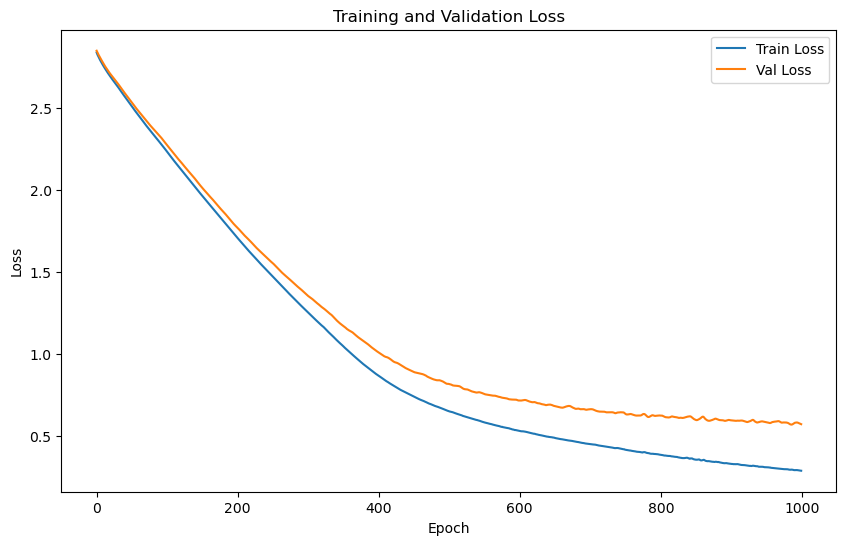

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7828 | Test Accuracy: 79.28%


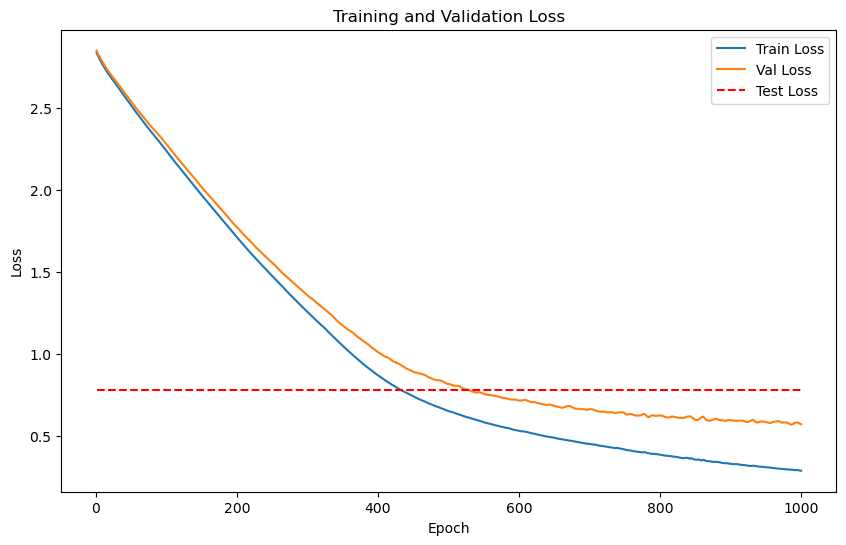

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3258
    Batch [2/2], Val Loss: 0.3595
Epoch [1/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3426

Validation loss improved from inf to 0.3426. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3258
    Batch [2/2], Val Loss: 0.3583
Epoch [2/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.3420

Validation loss improved from 0.3426 to 0.3420. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3262
    Batch [2/2], Val Loss: 0.3576
Epoch [3/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3266
    Batch [2/2], Val Loss: 0.3577
Epoch [4/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3268
    Batch [2/2], Val Loss: 0.3586
Epoch [5/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.3610
Epoch [6/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3297
    Batch [2/2], Val Loss: 0.3631
Epoch [7/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3317
    Batch [2/2], Val Loss: 0.3653
Epoch [8/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.3667
Epoch [9/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.3671
Epoch [10/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.3517

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3678
Epoch [11/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3529

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.3691
Epoch [12/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.3700
Epoch [13/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3401
    Batch [2/2], Val Loss: 0.3702
Epoch [14/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3407
    Batch [2/2], Val Loss: 0.3703
Epoch [15/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.3702
Epoch [16/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.3694
Epoch [17/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3416
    Batch [2/2], Val Loss: 0.3683
Epoch [18/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.3672
Epoch [19/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.3661
Epoch [20/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3535

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.3652
Epoch [21/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.3528

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.3642
Epoch [22/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3393
    Batch [2/2], Val Loss: 0.3630
Epoch [23/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3512

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.3619
Epoch [24/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3503

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3609
Epoch [25/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.3598
Epoch [26/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3367
    Batch [2/2], Val Loss: 0.3589
Epoch [27/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3478

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3360
    Batch [2/2], Val Loss: 0.3583
Epoch [28/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.3472

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3353
    Batch [2/2], Val Loss: 0.3576
Epoch [29/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3465

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3351
    Batch [2/2], Val Loss: 0.3573
Epoch [30/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.3570
Epoch [31/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3459

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3346
    Batch [2/2], Val Loss: 0.3567
Epoch [32/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3457

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.3565
Epoch [33/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3454

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.3562
Epoch [34/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.3560
Epoch [35/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.3558
Epoch [36/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.3448

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.3556
Epoch [37/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.3555
Epoch [38/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3334
    Batch [2/2], Val Loss: 0.3554
Epoch [39/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3333
    Batch [2/2], Val Loss: 0.3554
Epoch [40/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3443

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3332
    Batch [2/2], Val Loss: 0.3554
Epoch [41/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.3443

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3331
    Batch [2/2], Val Loss: 0.3553
Epoch [42/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3330
    Batch [2/2], Val Loss: 0.3553
Epoch [43/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.3553
Epoch [44/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3328
    Batch [2/2], Val Loss: 0.3553
Epoch [45/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3328
    Batch [2/2], Val Loss: 0.3554
Epoch [46/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3327
    Batch [2/2], Val Loss: 0.3554
Epoch [47/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3326
    Batch [2/2], Val Loss: 0.3554
Epoch [48/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3326
    Batch [2/2], Val Loss: 0.3554
Epoch [49/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3325
    Batch [2/2], Val Loss: 0.3554
Epoch [50/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.3554
Epoch [51/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.3554
Epoch [52/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3323
    Batch [2/2], Val Loss: 0.3554
Epoch [53/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3323
    Batch [2/2], Val Loss: 0.3554
Epoch [54/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3322
    Batch [2/2], Val Loss: 0.3554
Epoch [55/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3322
    Batch [2/2], Val Loss: 0.3554
Epoch [56/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3322
    Batch [2/2], Val Loss: 0.3554
Epoch [57/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3554
Epoch [58/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3554
Epoch [59/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3554
Epoch [60/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3554
Epoch [61/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [62/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [63/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [64/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [65/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [66/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [67/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3555
Epoch [68/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [69/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [70/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [71/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [72/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [73/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [74/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [75/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [76/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [77/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [78/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [79/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [80/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [81/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [82/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [83/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [84/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [85/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [86/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [87/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [88/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [89/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [90/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [91/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [92/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [93/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [94/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [95/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [96/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [97/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [98/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [99/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3555
Epoch [100/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3319
    Batch [2/2], Val Loss: 0.3555
Epoch [101/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3319
    Batch [2/2], Val Loss: 0.3555
Epoch [102/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3319
    Batch [2/2], Val Loss: 0.3555
Epoch [103/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 103!!
No improvement for 100 epochs


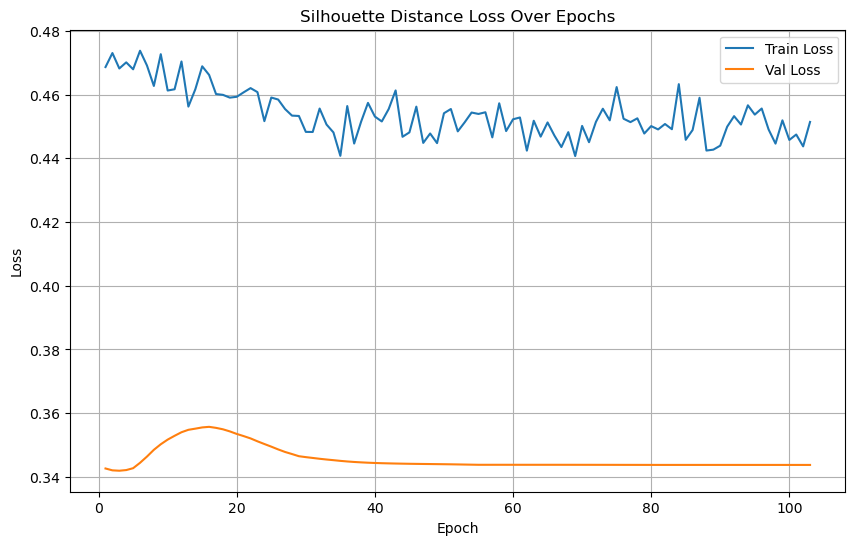

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/844], Loss: 0.1612
Test Batch [20/844], Loss: 0.1914
Test Batch [30/844], Loss: 0.2094
Test Batch [40/844], Loss: 0.1547
Test Batch [50/844], Loss: 0.1405
Test Batch [60/844], Loss: 0.5000


Test Batch [70/844], Loss: 0.1579
Test Batch [80/844], Loss: 0.2396
Test Batch [90/844], Loss: 0.5000
Test Batch [100/844], Loss: 0.2776
Test Batch [110/844], Loss: 0.2185
Test Batch [120/844], Loss: 0.2335
Test Batch [130/844], Loss: 0.5000
Test Batch [140/844], Loss: 0.5000


Test Batch [150/844], Loss: 0.2601
Test Batch [160/844], Loss: 0.3517
Test Batch [170/844], Loss: 0.3126
Test Batch [180/844], Loss: 0.2725
Test Batch [190/844], Loss: 0.2356


Test Batch [200/844], Loss: 0.1714
Test Batch [210/844], Loss: 0.1290
Test Batch [220/844], Loss: 0.1017
Test Batch [230/844], Loss: 0.2102
Test Batch [240/844], Loss: 0.1730


Test Batch [250/844], Loss: 0.2289
Test Batch [260/844], Loss: 0.3542
Test Batch [270/844], Loss: 0.3539
Test Batch [280/844], Loss: 0.3425


Test Batch [290/844], Loss: 0.3935
Test Batch [300/844], Loss: 0.2763
Test Batch [310/844], Loss: 0.2487
Test Batch [320/844], Loss: 0.2124
Test Batch [330/844], Loss: 0.3119
Test Batch [340/844], Loss: 0.2835
Test Batch [350/844], Loss: 0.5000


Test Batch [360/844], Loss: 0.1849
Test Batch [370/844], Loss: 0.5000
Test Batch [380/844], Loss: 0.5000
Test Batch [390/844], Loss: 0.5000
Test Batch [400/844], Loss: 0.5000
Test Batch [410/844], Loss: 0.5000
Test Batch [420/844], Loss: 0.5000
Test Batch [430/844], Loss: 0.0689
Test Batch [440/844], Loss: 0.0869
Test Batch [450/844], Loss: 0.2231


Test Batch [460/844], Loss: 0.1034
Test Batch [470/844], Loss: 0.1137
Test Batch [480/844], Loss: 0.2020
Test Batch [490/844], Loss: 0.5000
Test Batch [500/844], Loss: 0.2061
Test Batch [510/844], Loss: 0.2412
Test Batch [520/844], Loss: 0.1254


Test Batch [530/844], Loss: 0.1233
Test Batch [540/844], Loss: 0.2271
Test Batch [550/844], Loss: 0.1254
Test Batch [560/844], Loss: 0.1238
Test Batch [570/844], Loss: 0.1292
Test Batch [580/844], Loss: 0.1989


Test Batch [590/844], Loss: 0.2135
Test Batch [600/844], Loss: 0.1514
Test Batch [610/844], Loss: 0.2572
Test Batch [620/844], Loss: 0.2404
Test Batch [630/844], Loss: 0.3169


Test Batch [640/844], Loss: 0.2402
Test Batch [650/844], Loss: 0.1388
Test Batch [660/844], Loss: 0.1208
Test Batch [670/844], Loss: 0.1975
Test Batch [680/844], Loss: 0.1859


Test Batch [690/844], Loss: 0.1536
Test Batch [700/844], Loss: 0.3776
Test Batch [710/844], Loss: 0.1750
Test Batch [720/844], Loss: 0.4105
Test Batch [730/844], Loss: 0.1494


Test Batch [740/844], Loss: 0.1934
Test Batch [750/844], Loss: 0.2085
Test Batch [760/844], Loss: 0.4531
Test Batch [770/844], Loss: 0.5000
Test Batch [780/844], Loss: 0.2617
Test Batch [790/844], Loss: 0.2693
Test Batch [800/844], Loss: 0.3654


Test Batch [810/844], Loss: 0.1836
Test Batch [820/844], Loss: 0.1717
Test Batch [830/844], Loss: 0.1733
Test Batch [840/844], Loss: 0.2125

Test Loss: 0.2723


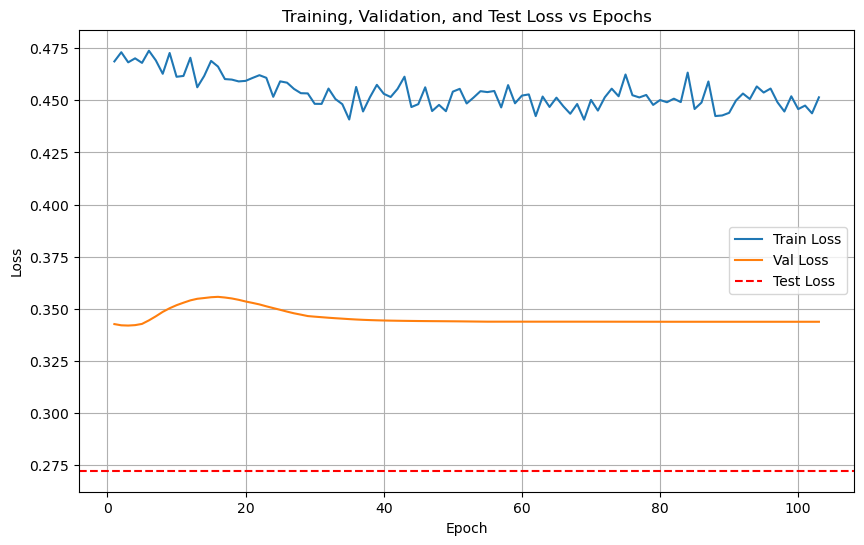

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/844 for test dataset.


  Processed batch 20/844 for test dataset.
  Processed batch 30/844 for test dataset.
  Processed batch 40/844 for test dataset.


  Processed batch 50/844 for test dataset.
  Processed batch 60/844 for test dataset.
  Processed batch 70/844 for test dataset.
  Processed batch 80/844 for test dataset.


  Processed batch 90/844 for test dataset.
  Processed batch 100/844 for test dataset.
  Processed batch 110/844 for test dataset.
  Processed batch 120/844 for test dataset.


  Processed batch 130/844 for test dataset.
  Processed batch 140/844 for test dataset.
  Processed batch 150/844 for test dataset.


  Processed batch 160/844 for test dataset.
  Processed batch 170/844 for test dataset.
  Processed batch 180/844 for test dataset.


  Processed batch 190/844 for test dataset.
  Processed batch 200/844 for test dataset.
  Processed batch 210/844 for test dataset.
  Processed batch 220/844 for test dataset.


  Processed batch 230/844 for test dataset.
  Processed batch 240/844 for test dataset.


  Processed batch 250/844 for test dataset.
  Processed batch 260/844 for test dataset.
  Processed batch 270/844 for test dataset.


  Processed batch 280/844 for test dataset.
  Processed batch 290/844 for test dataset.
  Processed batch 300/844 for test dataset.
  Processed batch 310/844 for test dataset.


  Processed batch 320/844 for test dataset.
  Processed batch 330/844 for test dataset.
  Processed batch 340/844 for test dataset.
  Processed batch 350/844 for test dataset.


  Processed batch 360/844 for test dataset.
  Processed batch 370/844 for test dataset.
  Processed batch 380/844 for test dataset.


  Processed batch 390/844 for test dataset.
  Processed batch 400/844 for test dataset.
  Processed batch 410/844 for test dataset.
  Processed batch 420/844 for test dataset.


  Processed batch 430/844 for test dataset.
  Processed batch 440/844 for test dataset.
  Processed batch 450/844 for test dataset.


  Processed batch 460/844 for test dataset.
  Processed batch 470/844 for test dataset.
  Processed batch 480/844 for test dataset.
  Processed batch 490/844 for test dataset.


  Processed batch 500/844 for test dataset.
  Processed batch 510/844 for test dataset.
  Processed batch 520/844 for test dataset.


  Processed batch 530/844 for test dataset.
  Processed batch 540/844 for test dataset.
  Processed batch 550/844 for test dataset.
  Processed batch 560/844 for test dataset.


  Processed batch 570/844 for test dataset.
  Processed batch 580/844 for test dataset.
  Processed batch 590/844 for test dataset.
  Processed batch 600/844 for test dataset.


  Processed batch 610/844 for test dataset.
  Processed batch 620/844 for test dataset.
  Processed batch 630/844 for test dataset.
  Processed batch 640/844 for test dataset.


  Processed batch 650/844 for test dataset.
  Processed batch 660/844 for test dataset.
  Processed batch 670/844 for test dataset.
  Processed batch 680/844 for test dataset.


  Processed batch 690/844 for test dataset.
  Processed batch 700/844 for test dataset.


  Processed batch 710/844 for test dataset.
  Processed batch 720/844 for test dataset.


  Processed batch 730/844 for test dataset.
  Processed batch 740/844 for test dataset.
  Processed batch 750/844 for test dataset.


  Processed batch 760/844 for test dataset.
  Processed batch 770/844 for test dataset.
  Processed batch 780/844 for test dataset.


  Processed batch 790/844 for test dataset.
  Processed batch 800/844 for test dataset.
  Processed batch 810/844 for test dataset.


  Processed batch 820/844 for test dataset.
  Processed batch 830/844 for test dataset.
  Processed batch 840/844 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       0.67      0.40      0.50         5
           8       0.62      1.00      0.77         5
           9       0.60      0.60      0.60         5
          10       0.50      0.40      0.44         5
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7809  |  Val Loss: 2.7827
Validation loss improved from inf to 2.7827.
[Epoch 2/1000] Train Loss: 2.7728  |  Val Loss: 2.7762
Validation loss improved from 2.7827 to 2.7762.
[Epoch 3/1000] Train Loss: 2.7657  |  Val Loss: 2.7700
Validation loss improved from 2.7762 to 2.7700.
[Epoch 4/1000] Train Loss: 2.7588  |  Val Loss: 2.7639
Validation loss improved from 2.7700 to 2.7639.
[Epoch 5/1000] Train Loss: 2.7520  |  Val Loss: 2.7579
Validation loss improved from 2.7639 to 2.7579.
[Epoch 6/1000] Train Loss: 2.7452  |  Val Loss: 2.7519
Validation loss improved from 2.7579 to 2.7519.
[Epoch 7/1000] Train Loss: 2.7384  |  Val Loss: 2.7460
Validation loss improved from 2.7519 to 2.7460.
[Epoch 8/1000] Train Loss: 2.7319  |  Val Loss: 2.7403
Validation loss improved from 2.7460 to 2.7403.
[Epoch 9/1000] Train Loss: 2.7253  |  Val Loss: 2.7345
Validation loss improved from 2.7403 to 2.7345.
[Epoch 10/1000] Train Loss: 2.7188  |  Val Loss: 2.7287
Validation loss impr

[Epoch 36/1000] Train Loss: 2.5499  |  Val Loss: 2.5672
Validation loss improved from 2.5739 to 2.5672.
[Epoch 37/1000] Train Loss: 2.5433  |  Val Loss: 2.5605
Validation loss improved from 2.5672 to 2.5605.
[Epoch 38/1000] Train Loss: 2.5363  |  Val Loss: 2.5538
Validation loss improved from 2.5605 to 2.5538.
[Epoch 39/1000] Train Loss: 2.5292  |  Val Loss: 2.5470
Validation loss improved from 2.5538 to 2.5470.
[Epoch 40/1000] Train Loss: 2.5221  |  Val Loss: 2.5401
Validation loss improved from 2.5470 to 2.5401.
[Epoch 41/1000] Train Loss: 2.5151  |  Val Loss: 2.5329
Validation loss improved from 2.5401 to 2.5329.
[Epoch 42/1000] Train Loss: 2.5079  |  Val Loss: 2.5258
Validation loss improved from 2.5329 to 2.5258.
[Epoch 43/1000] Train Loss: 2.5004  |  Val Loss: 2.5188
Validation loss improved from 2.5258 to 2.5188.
[Epoch 44/1000] Train Loss: 2.4930  |  Val Loss: 2.5116
Validation loss improved from 2.5188 to 2.5116.
[Epoch 45/1000] Train Loss: 2.4862  |  Val Loss: 2.5044
Validati

[Epoch 73/1000] Train Loss: 2.2664  |  Val Loss: 2.2948
Validation loss improved from 2.3028 to 2.2948.
[Epoch 74/1000] Train Loss: 2.2578  |  Val Loss: 2.2868
Validation loss improved from 2.2948 to 2.2868.
[Epoch 75/1000] Train Loss: 2.2493  |  Val Loss: 2.2787
Validation loss improved from 2.2868 to 2.2787.
[Epoch 76/1000] Train Loss: 2.2405  |  Val Loss: 2.2705
Validation loss improved from 2.2787 to 2.2705.
[Epoch 77/1000] Train Loss: 2.2321  |  Val Loss: 2.2621
Validation loss improved from 2.2705 to 2.2621.
[Epoch 78/1000] Train Loss: 2.2235  |  Val Loss: 2.2540
Validation loss improved from 2.2621 to 2.2540.
[Epoch 79/1000] Train Loss: 2.2150  |  Val Loss: 2.2461
Validation loss improved from 2.2540 to 2.2461.
[Epoch 80/1000] Train Loss: 2.2063  |  Val Loss: 2.2383
Validation loss improved from 2.2461 to 2.2383.
[Epoch 81/1000] Train Loss: 2.1979  |  Val Loss: 2.2303
Validation loss improved from 2.2383 to 2.2303.
[Epoch 82/1000] Train Loss: 2.1894  |  Val Loss: 2.2223
Validati

[Epoch 110/1000] Train Loss: 1.9510  |  Val Loss: 2.0044
Validation loss improved from 2.0118 to 2.0044.
[Epoch 111/1000] Train Loss: 1.9425  |  Val Loss: 1.9970
Validation loss improved from 2.0044 to 1.9970.
[Epoch 112/1000] Train Loss: 1.9345  |  Val Loss: 1.9896
Validation loss improved from 1.9970 to 1.9896.
[Epoch 113/1000] Train Loss: 1.9262  |  Val Loss: 1.9821
Validation loss improved from 1.9896 to 1.9821.
[Epoch 114/1000] Train Loss: 1.9181  |  Val Loss: 1.9746
Validation loss improved from 1.9821 to 1.9746.
[Epoch 115/1000] Train Loss: 1.9097  |  Val Loss: 1.9671
Validation loss improved from 1.9746 to 1.9671.
[Epoch 116/1000] Train Loss: 1.9015  |  Val Loss: 1.9598
Validation loss improved from 1.9671 to 1.9598.
[Epoch 117/1000] Train Loss: 1.8935  |  Val Loss: 1.9526
Validation loss improved from 1.9598 to 1.9526.
[Epoch 118/1000] Train Loss: 1.8853  |  Val Loss: 1.9454
Validation loss improved from 1.9526 to 1.9454.
[Epoch 119/1000] Train Loss: 1.8770  |  Val Loss: 1.938

[Epoch 150/1000] Train Loss: 1.6314  |  Val Loss: 1.7191
Validation loss improved from 1.7256 to 1.7191.
[Epoch 151/1000] Train Loss: 1.6238  |  Val Loss: 1.7125
Validation loss improved from 1.7191 to 1.7125.
[Epoch 152/1000] Train Loss: 1.6163  |  Val Loss: 1.7059
Validation loss improved from 1.7125 to 1.7059.
[Epoch 153/1000] Train Loss: 1.6090  |  Val Loss: 1.6993
Validation loss improved from 1.7059 to 1.6993.
[Epoch 154/1000] Train Loss: 1.6013  |  Val Loss: 1.6926
Validation loss improved from 1.6993 to 1.6926.
[Epoch 155/1000] Train Loss: 1.5938  |  Val Loss: 1.6859
Validation loss improved from 1.6926 to 1.6859.
[Epoch 156/1000] Train Loss: 1.5866  |  Val Loss: 1.6791
Validation loss improved from 1.6859 to 1.6791.
[Epoch 157/1000] Train Loss: 1.5789  |  Val Loss: 1.6722
Validation loss improved from 1.6791 to 1.6722.
[Epoch 158/1000] Train Loss: 1.5717  |  Val Loss: 1.6653
Validation loss improved from 1.6722 to 1.6653.
[Epoch 159/1000] Train Loss: 1.5642  |  Val Loss: 1.658

[Epoch 191/1000] Train Loss: 1.3396  |  Val Loss: 1.4647
Validation loss improved from 1.4707 to 1.4647.
[Epoch 192/1000] Train Loss: 1.3329  |  Val Loss: 1.4588
Validation loss improved from 1.4647 to 1.4588.
[Epoch 193/1000] Train Loss: 1.3262  |  Val Loss: 1.4526
Validation loss improved from 1.4588 to 1.4526.
[Epoch 194/1000] Train Loss: 1.3195  |  Val Loss: 1.4465
Validation loss improved from 1.4526 to 1.4465.
[Epoch 195/1000] Train Loss: 1.3128  |  Val Loss: 1.4406
Validation loss improved from 1.4465 to 1.4406.
[Epoch 196/1000] Train Loss: 1.3066  |  Val Loss: 1.4348
Validation loss improved from 1.4406 to 1.4348.
[Epoch 197/1000] Train Loss: 1.3002  |  Val Loss: 1.4290
Validation loss improved from 1.4348 to 1.4290.
[Epoch 198/1000] Train Loss: 1.2936  |  Val Loss: 1.4230
Validation loss improved from 1.4290 to 1.4230.
[Epoch 199/1000] Train Loss: 1.2872  |  Val Loss: 1.4173
Validation loss improved from 1.4230 to 1.4173.
[Epoch 200/1000] Train Loss: 1.2805  |  Val Loss: 1.411

[Epoch 236/1000] Train Loss: 1.0503  |  Val Loss: 1.2252
Validation loss improved from 1.2301 to 1.2252.
[Epoch 237/1000] Train Loss: 1.0440  |  Val Loss: 1.2206
Validation loss improved from 1.2252 to 1.2206.
[Epoch 238/1000] Train Loss: 1.0376  |  Val Loss: 1.2164
Validation loss improved from 1.2206 to 1.2164.
[Epoch 239/1000] Train Loss: 1.0312  |  Val Loss: 1.2125
Validation loss improved from 1.2164 to 1.2125.
[Epoch 240/1000] Train Loss: 1.0251  |  Val Loss: 1.2084
Validation loss improved from 1.2125 to 1.2084.
[Epoch 241/1000] Train Loss: 1.0195  |  Val Loss: 1.2041
Validation loss improved from 1.2084 to 1.2041.
[Epoch 242/1000] Train Loss: 1.0131  |  Val Loss: 1.1996
Validation loss improved from 1.2041 to 1.1996.
[Epoch 243/1000] Train Loss: 1.0071  |  Val Loss: 1.1952
Validation loss improved from 1.1996 to 1.1952.
[Epoch 244/1000] Train Loss: 1.0012  |  Val Loss: 1.1912
Validation loss improved from 1.1952 to 1.1912.
[Epoch 245/1000] Train Loss: 0.9956  |  Val Loss: 1.187

[Epoch 279/1000] Train Loss: 0.8098  |  Val Loss: 1.0362
Validation loss improved from 1.0397 to 1.0362.
[Epoch 280/1000] Train Loss: 0.8048  |  Val Loss: 1.0329
Validation loss improved from 1.0362 to 1.0329.
[Epoch 281/1000] Train Loss: 0.8000  |  Val Loss: 1.0298
Validation loss improved from 1.0329 to 1.0298.
[Epoch 282/1000] Train Loss: 0.7953  |  Val Loss: 1.0266
Validation loss improved from 1.0298 to 1.0266.
[Epoch 283/1000] Train Loss: 0.7912  |  Val Loss: 1.0232
Validation loss improved from 1.0266 to 1.0232.
[Epoch 284/1000] Train Loss: 0.7862  |  Val Loss: 1.0196
Validation loss improved from 1.0232 to 1.0196.
[Epoch 285/1000] Train Loss: 0.7814  |  Val Loss: 1.0157
Validation loss improved from 1.0196 to 1.0157.
[Epoch 286/1000] Train Loss: 0.7768  |  Val Loss: 1.0116
Validation loss improved from 1.0157 to 1.0116.
[Epoch 287/1000] Train Loss: 0.7723  |  Val Loss: 1.0077
Validation loss improved from 1.0116 to 1.0077.
[Epoch 288/1000] Train Loss: 0.7680  |  Val Loss: 1.004

[Epoch 319/1000] Train Loss: 0.6386  |  Val Loss: 0.9090
Validation loss improved from 0.9121 to 0.9090.
[Epoch 320/1000] Train Loss: 0.6351  |  Val Loss: 0.9062
Validation loss improved from 0.9090 to 0.9062.
[Epoch 321/1000] Train Loss: 0.6315  |  Val Loss: 0.9034
Validation loss improved from 0.9062 to 0.9034.
[Epoch 322/1000] Train Loss: 0.6278  |  Val Loss: 0.9005
Validation loss improved from 0.9034 to 0.9005.
[Epoch 323/1000] Train Loss: 0.6245  |  Val Loss: 0.8977
Validation loss improved from 0.9005 to 0.8977.
[Epoch 324/1000] Train Loss: 0.6207  |  Val Loss: 0.8947
Validation loss improved from 0.8977 to 0.8947.
[Epoch 325/1000] Train Loss: 0.6175  |  Val Loss: 0.8915
Validation loss improved from 0.8947 to 0.8915.
[Epoch 326/1000] Train Loss: 0.6141  |  Val Loss: 0.8884
Validation loss improved from 0.8915 to 0.8884.
[Epoch 327/1000] Train Loss: 0.6106  |  Val Loss: 0.8852
Validation loss improved from 0.8884 to 0.8852.
[Epoch 328/1000] Train Loss: 0.6072  |  Val Loss: 0.882

[Epoch 358/1000] Train Loss: 0.5149  |  Val Loss: 0.8255
Validation loss improved from 0.8282 to 0.8255.
[Epoch 359/1000] Train Loss: 0.5121  |  Val Loss: 0.8229
Validation loss improved from 0.8255 to 0.8229.
[Epoch 360/1000] Train Loss: 0.5092  |  Val Loss: 0.8205
Validation loss improved from 0.8229 to 0.8205.
[Epoch 361/1000] Train Loss: 0.5066  |  Val Loss: 0.8180
Validation loss improved from 0.8205 to 0.8180.
[Epoch 362/1000] Train Loss: 0.5039  |  Val Loss: 0.8154
Validation loss improved from 0.8180 to 0.8154.
[Epoch 363/1000] Train Loss: 0.5013  |  Val Loss: 0.8130
Validation loss improved from 0.8154 to 0.8130.
[Epoch 364/1000] Train Loss: 0.4987  |  Val Loss: 0.8107
Validation loss improved from 0.8130 to 0.8107.
[Epoch 365/1000] Train Loss: 0.4963  |  Val Loss: 0.8081
Validation loss improved from 0.8107 to 0.8081.
[Epoch 366/1000] Train Loss: 0.4938  |  Val Loss: 0.8056
Validation loss improved from 0.8081 to 0.8056.
[Epoch 367/1000] Train Loss: 0.4910  |  Val Loss: 0.803

[Epoch 398/1000] Train Loss: 0.4234  |  Val Loss: 0.7536
Validation loss improved from 0.7549 to 0.7536.
[Epoch 399/1000] Train Loss: 0.4215  |  Val Loss: 0.7523
Validation loss improved from 0.7536 to 0.7523.
[Epoch 400/1000] Train Loss: 0.4195  |  Val Loss: 0.7511
Validation loss improved from 0.7523 to 0.7511.
[Epoch 401/1000] Train Loss: 0.4179  |  Val Loss: 0.7498
Validation loss improved from 0.7511 to 0.7498.
[Epoch 402/1000] Train Loss: 0.4156  |  Val Loss: 0.7486
Validation loss improved from 0.7498 to 0.7486.
[Epoch 403/1000] Train Loss: 0.4137  |  Val Loss: 0.7474
Validation loss improved from 0.7486 to 0.7474.
[Epoch 404/1000] Train Loss: 0.4116  |  Val Loss: 0.7463
Validation loss improved from 0.7474 to 0.7463.
[Epoch 405/1000] Train Loss: 0.4098  |  Val Loss: 0.7457
Validation loss improved from 0.7463 to 0.7457.
[Epoch 406/1000] Train Loss: 0.4081  |  Val Loss: 0.7452
Validation loss improved from 0.7457 to 0.7452.
[Epoch 407/1000] Train Loss: 0.4064  |  Val Loss: 0.744

[Epoch 436/1000] Train Loss: 0.3589  |  Val Loss: 0.7175
Validation loss improved from 0.7180 to 0.7175.
[Epoch 437/1000] Train Loss: 0.3573  |  Val Loss: 0.7163
Validation loss improved from 0.7175 to 0.7163.
[Epoch 438/1000] Train Loss: 0.3557  |  Val Loss: 0.7146
Validation loss improved from 0.7163 to 0.7146.
[Epoch 439/1000] Train Loss: 0.3544  |  Val Loss: 0.7127
Validation loss improved from 0.7146 to 0.7127.
[Epoch 440/1000] Train Loss: 0.3528  |  Val Loss: 0.7110
Validation loss improved from 0.7127 to 0.7110.
[Epoch 441/1000] Train Loss: 0.3511  |  Val Loss: 0.7094
Validation loss improved from 0.7110 to 0.7094.
[Epoch 442/1000] Train Loss: 0.3499  |  Val Loss: 0.7076
Validation loss improved from 0.7094 to 0.7076.
[Epoch 443/1000] Train Loss: 0.3488  |  Val Loss: 0.7055
Validation loss improved from 0.7076 to 0.7055.
[Epoch 444/1000] Train Loss: 0.3478  |  Val Loss: 0.7039
Validation loss improved from 0.7055 to 0.7039.
[Epoch 445/1000] Train Loss: 0.3463  |  Val Loss: 0.702

[Epoch 478/1000] Train Loss: 0.3055  |  Val Loss: 0.6792
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 479/1000] Train Loss: 0.3043  |  Val Loss: 0.6798
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 480/1000] Train Loss: 0.3030  |  Val Loss: 0.6803
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 481/1000] Train Loss: 0.3025  |  Val Loss: 0.6808
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 482/1000] Train Loss: 0.3013  |  Val Loss: 0.6808
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 483/1000] Train Loss: 0.3001  |  Val Loss: 0.6807
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 484/1000] Train Loss: 0.2991  |  Val Loss: 0.6808
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 485/1000] Train Loss: 0.2979  |  Val Loss: 0.6811
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 486/1000] Train Loss: 0.2965  |  Val Loss: 0.6817
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 518/1000] Train Loss: 0.2658  |  Val Loss: 0.6587
Validation loss improved from 0.6590 to 0.6587.
[Epoch 519/1000] Train Loss: 0.2647  |  Val Loss: 0.6581
Validation loss improved from 0.6587 to 0.6581.
[Epoch 520/1000] Train Loss: 0.2640  |  Val Loss: 0.6575
Validation loss improved from 0.6581 to 0.6575.
[Epoch 521/1000] Train Loss: 0.2634  |  Val Loss: 0.6571
Validation loss improved from 0.6575 to 0.6571.
[Epoch 522/1000] Train Loss: 0.2625  |  Val Loss: 0.6564
Validation loss improved from 0.6571 to 0.6564.
[Epoch 523/1000] Train Loss: 0.2617  |  Val Loss: 0.6558
Validation loss improved from 0.6564 to 0.6558.
[Epoch 524/1000] Train Loss: 0.2608  |  Val Loss: 0.6558
Validation loss improved from 0.6558 to 0.6558.
[Epoch 525/1000] Train Loss: 0.2599  |  Val Loss: 0.6559
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 526/1000] Train Loss: 0.2591  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 527/1000] Train Loss: 0.2585  |  Val

[Epoch 559/1000] Train Loss: 0.2328  |  Val Loss: 0.6513
Validation loss improved from 0.6525 to 0.6513.
[Epoch 560/1000] Train Loss: 0.2320  |  Val Loss: 0.6507
Validation loss improved from 0.6513 to 0.6507.
[Epoch 561/1000] Train Loss: 0.2314  |  Val Loss: 0.6503
Validation loss improved from 0.6507 to 0.6503.
[Epoch 562/1000] Train Loss: 0.2305  |  Val Loss: 0.6498
Validation loss improved from 0.6503 to 0.6498.
[Epoch 563/1000] Train Loss: 0.2298  |  Val Loss: 0.6491
Validation loss improved from 0.6498 to 0.6491.
[Epoch 564/1000] Train Loss: 0.2294  |  Val Loss: 0.6484
Validation loss improved from 0.6491 to 0.6484.
[Epoch 565/1000] Train Loss: 0.2289  |  Val Loss: 0.6483
Validation loss improved from 0.6484 to 0.6483.
[Epoch 566/1000] Train Loss: 0.2289  |  Val Loss: 0.6490
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 567/1000] Train Loss: 0.2280  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 568/1000] Train Loss: 0.2270  |  Val

[Epoch 599/1000] Train Loss: 0.2075  |  Val Loss: 0.6541
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 600/1000] Train Loss: 0.2071  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 601/1000] Train Loss: 0.2069  |  Val Loss: 0.6545
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 602/1000] Train Loss: 0.2061  |  Val Loss: 0.6534
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 603/1000] Train Loss: 0.2052  |  Val Loss: 0.6519
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 604/1000] Train Loss: 0.2048  |  Val Loss: 0.6502
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 605/1000] Train Loss: 0.2041  |  Val Loss: 0.6490
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 606/1000] Train Loss: 0.2036  |  Val Loss: 0.6477
Validation loss improved from 0.6483 to 0.6477.
[Epoch 607/1000] Train Loss: 0.2030  |  Val Loss: 0.6467
Validation loss improved from 0.6477 to 0.6467.
[Epoch

[Epoch 642/1000] Train Loss: 0.1842  |  Val Loss: 0.6469
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 643/1000] Train Loss: 0.1838  |  Val Loss: 0.6464
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 644/1000] Train Loss: 0.1838  |  Val Loss: 0.6460
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 645/1000] Train Loss: 0.1831  |  Val Loss: 0.6454
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 646/1000] Train Loss: 0.1826  |  Val Loss: 0.6445
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 647/1000] Train Loss: 0.1820  |  Val Loss: 0.6436
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 648/1000] Train Loss: 0.1814  |  Val Loss: 0.6427
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 649/1000] Train Loss: 0.1814  |  Val Loss: 0.6423
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 650/1000] Train Loss: 0.1804  |  Val Loss: 0.6421
!! Validation loss did NOT improve !! Patience:

[Epoch 682/1000] Train Loss: 0.1669  |  Val Loss: 0.6427
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 683/1000] Train Loss: 0.1666  |  Val Loss: 0.6425
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 684/1000] Train Loss: 0.1667  |  Val Loss: 0.6426
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 685/1000] Train Loss: 0.1660  |  Val Loss: 0.6441
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 686/1000] Train Loss: 0.1656  |  Val Loss: 0.6451
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 687/1000] Train Loss: 0.1653  |  Val Loss: 0.6462
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 688/1000] Train Loss: 0.1650  |  Val Loss: 0.6472
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 689/1000] Train Loss: 0.1644  |  Val Loss: 0.6470
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 690/1000] Train Loss: 0.1640  |  Val Loss: 0.6468
!! Validation loss did NOT improve !! Patience: 1

[Epoch 719/1000] Train Loss: 0.1520  |  Val Loss: 0.6389
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 720/1000] Train Loss: 0.1517  |  Val Loss: 0.6393
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 721/1000] Train Loss: 0.1512  |  Val Loss: 0.6399
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 722/1000] Train Loss: 0.1508  |  Val Loss: 0.6405
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 723/1000] Train Loss: 0.1504  |  Val Loss: 0.6421
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 724/1000] Train Loss: 0.1499  |  Val Loss: 0.6448
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 725/1000] Train Loss: 0.1501  |  Val Loss: 0.6470
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 726/1000] Train Loss: 0.1498  |  Val Loss: 0.6478
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 727/1000] Train Loss: 0.1495  |  Val Loss: 0.6478
!! Validation loss did NOT improve !! Patience:

[Epoch 763/1000] Train Loss: 0.1377  |  Val Loss: 0.6469
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 764/1000] Train Loss: 0.1373  |  Val Loss: 0.6463
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 765/1000] Train Loss: 0.1370  |  Val Loss: 0.6457
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 766/1000] Train Loss: 0.1370  |  Val Loss: 0.6450
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 767/1000] Train Loss: 0.1366  |  Val Loss: 0.6449
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 768/1000] Train Loss: 0.1363  |  Val Loss: 0.6445
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 769/1000] Train Loss: 0.1359  |  Val Loss: 0.6433
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 770/1000] Train Loss: 0.1356  |  Val Loss: 0.6414
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 771/1000] Train Loss: 0.1355  |  Val Loss: 0.6396
!! Validation loss did NOT improve !! Patience:

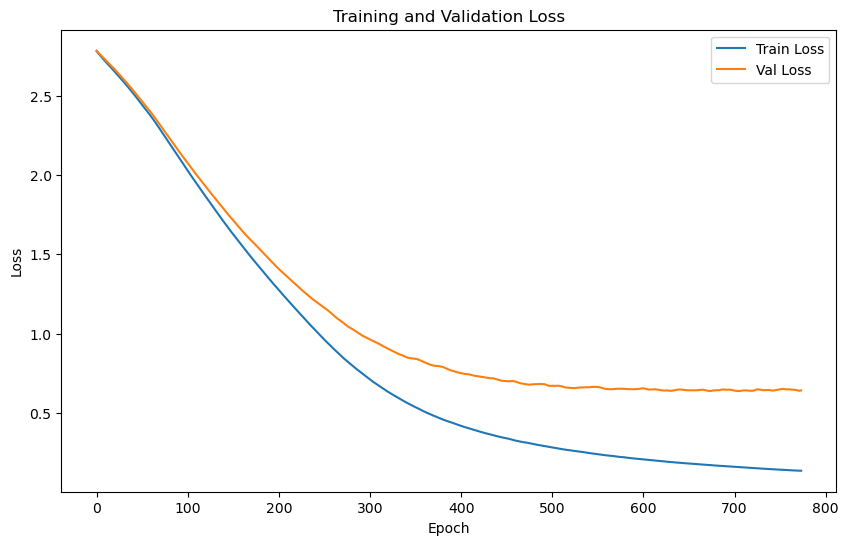

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7222 | Test Accuracy: 78.55%


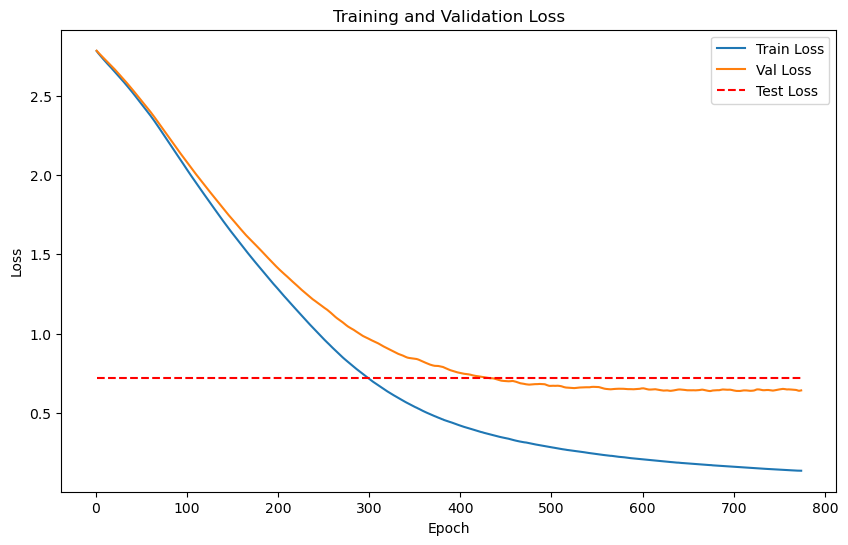

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


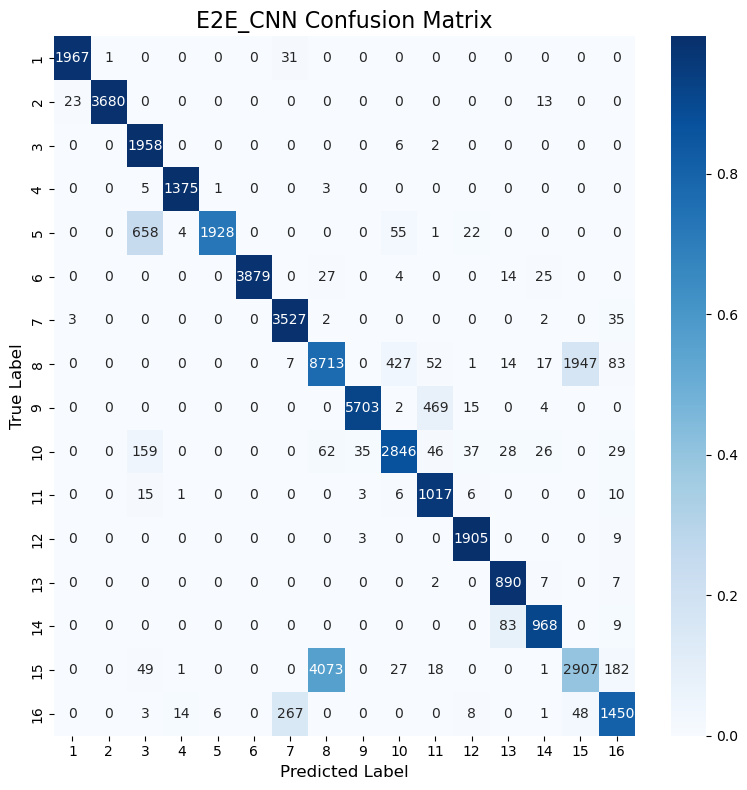

Classification Accuracy: 82.85%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


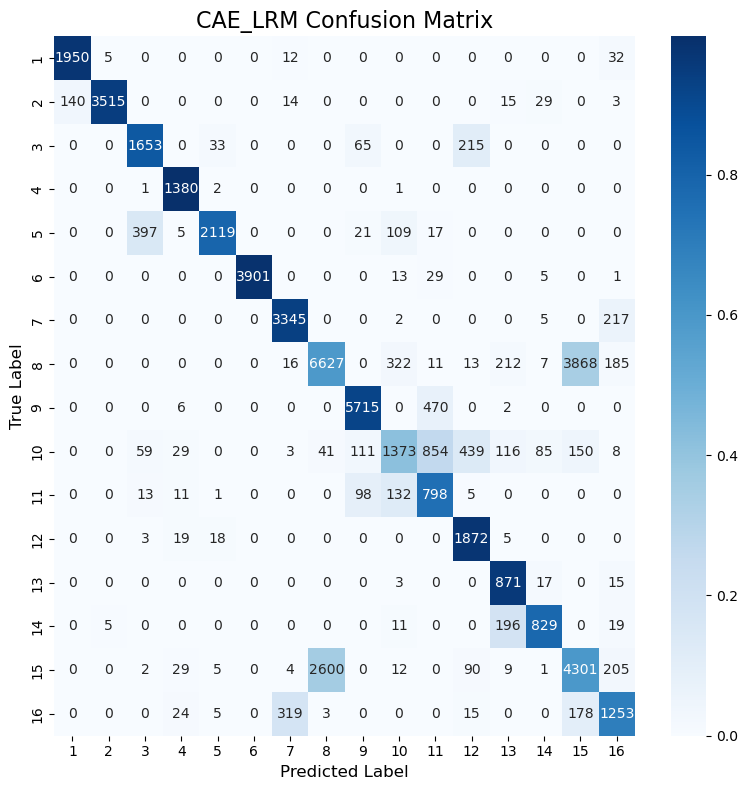

Classification Accuracy: 76.90%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


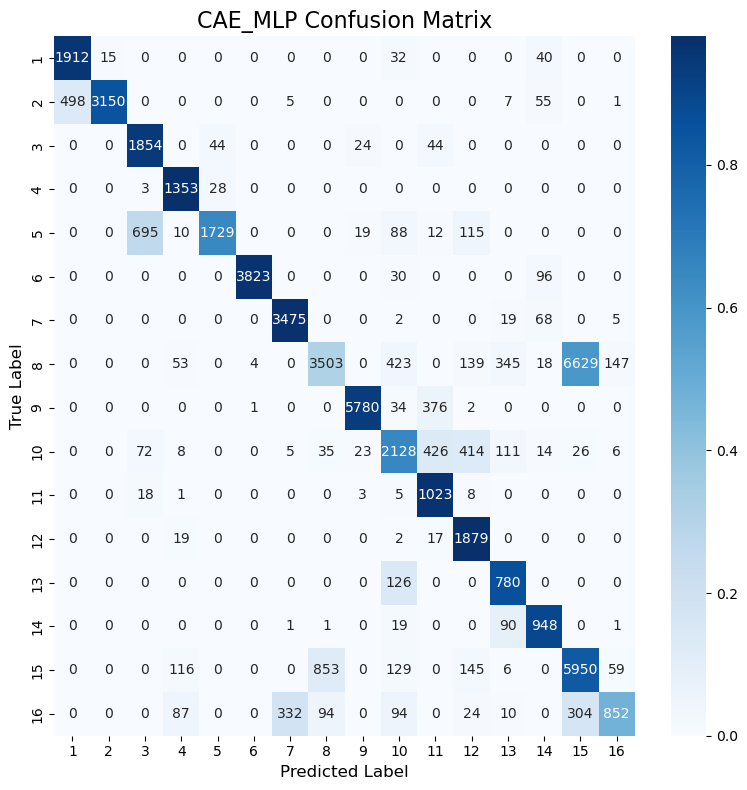

Classification Accuracy: 74.37%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


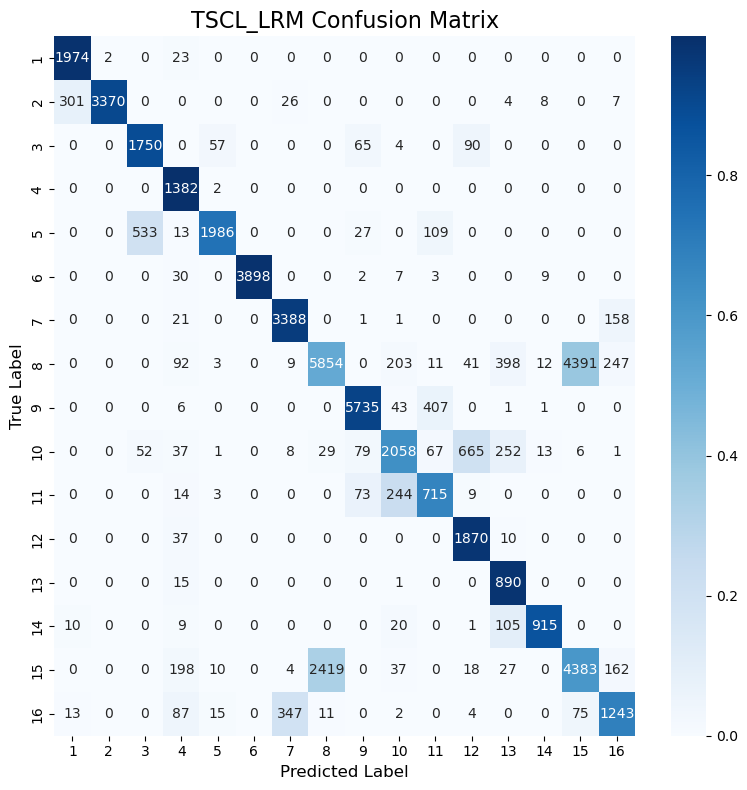

Classification Accuracy: 76.73%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


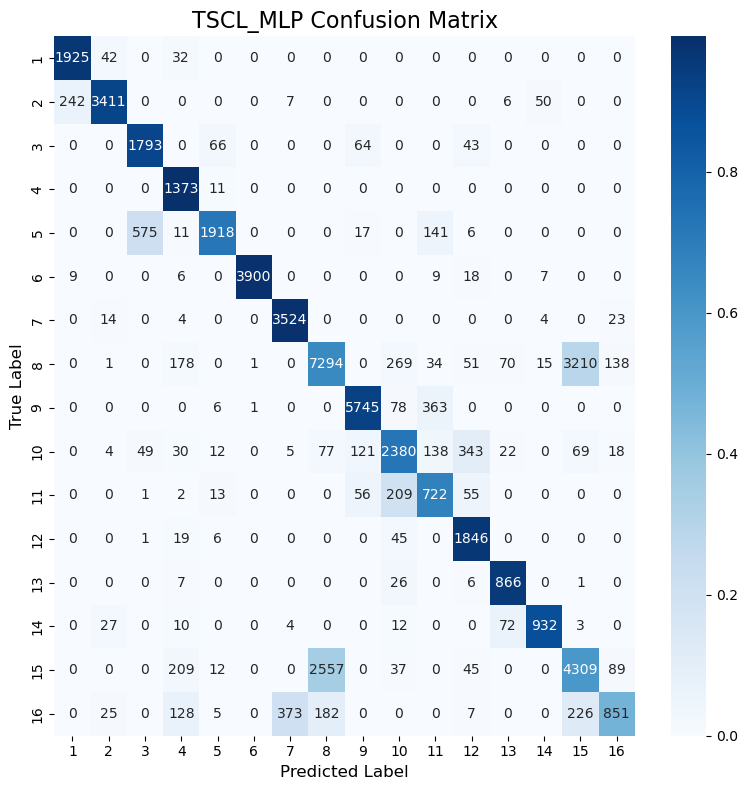

Classification Accuracy: 79.28%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


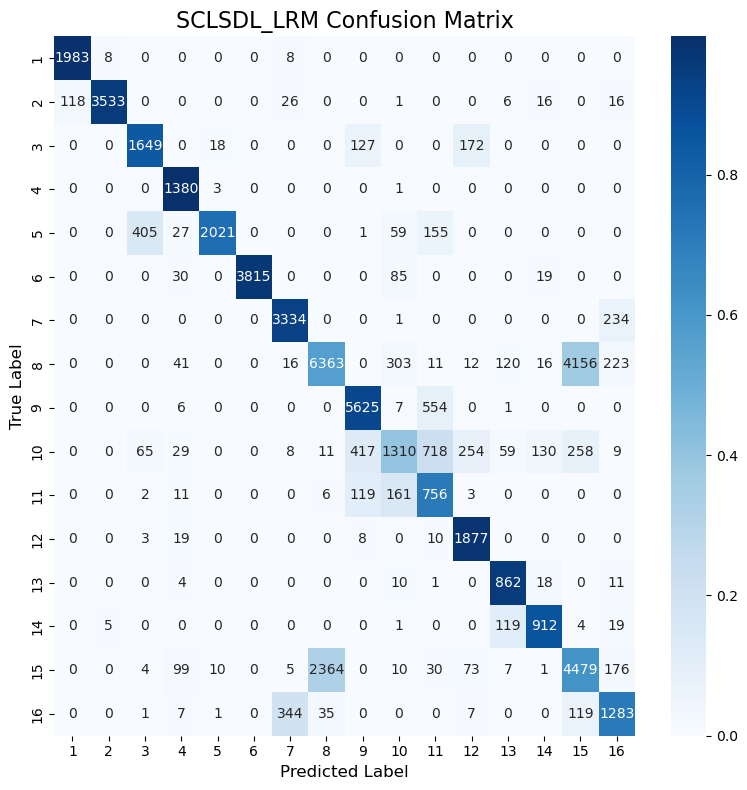

Classification Accuracy: 76.31%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


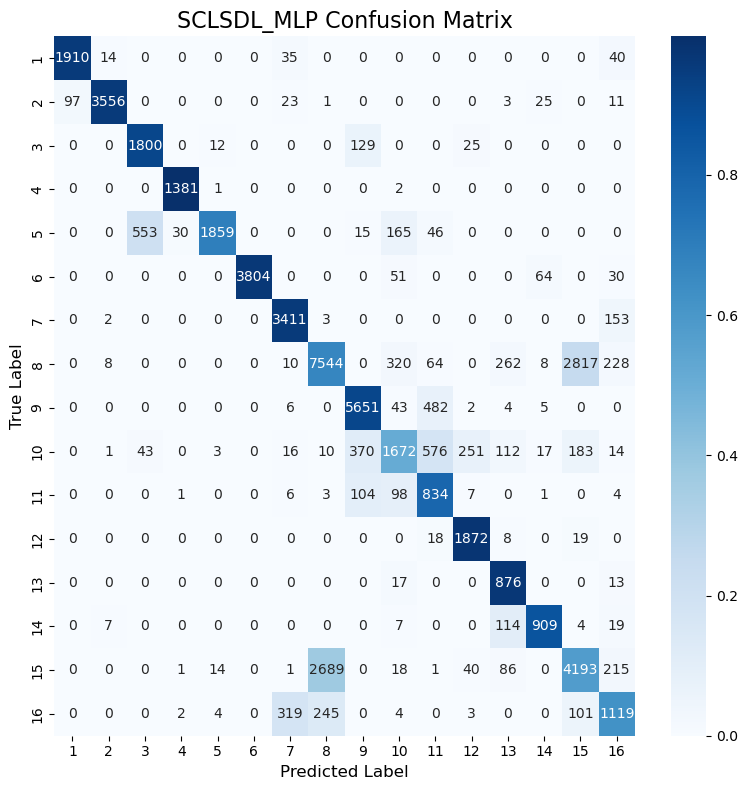

Classification Accuracy: 78.55%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          82.85
1    LRM (CAE)          76.90
2    MLP (CAE)          74.37
3     TSCL LRM          76.73
4     TSCL MLP          79.28
5  SCL_SDL LRM          76.31
6  SCL_SDL MLP          78.55

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          82.85
4     TSCL MLP          79.28
6  SCL_SDL MLP          78.55
1    LRM (CAE)          76.90
3     TSCL LRM          76.73
5  SCL_SDL LRM          76.31
2    MLP (CAE)          74.37
